# Проект: прогнозирование оттока клиентов ТелеДом

Заказчик: Оператор связи «ТелеДом»

Цель: Снизить отток клиентов Заказчика путем таргетированной рассылки промокодов и специальных условий.

Задача: Подготовка модели машинного обучения для предсказания оттока клиентов.

Основная метрика: **ROC AUC** 

Целевое значение метрики: **ROC-AUC >= 0.85**

Дополнительные метрики: Accuracy c Confusion Matrix

Дополнительно: выгрузка проведена 1 февраля 2020 года.

In [1]:
# Установка библиотек
!pip install numba==0.60 -q
!pip install seaborn==0.13.2 -q
!pip install phik -q
!pip install optuna -q
!pip install shap -q
!pip install category_encoders -q
!pip install -U scikit-learn -q

In [2]:
# Импорт библиотек, классов и функций
import gc

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import optuna
import catboost as cb
import shap
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import RidgeClassifier
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost.utils import get_gpu_device_count
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix

In [3]:
# Константы и настройка

RANDOM_STATE = 28102024
LAST_DATE = "2020-02-01"
CV = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
SCORING = ["roc_auc", "accuracy"]
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Загрузка данных

In [4]:
try:
    df_contract = pd.read_csv("/datasets/contract_new.csv", parse_dates=["BeginDate"])
    df_personal = pd.read_csv("/datasets/personal_new.csv")
    df_internet = pd.read_csv("/datasets/internet_new.csv")
    df_phone = pd.read_csv("/datasets/phone_new.csv")
except:
    df_contract = pd.read_csv("https://code.s3.yandex.net/datasets/contract_new.csv", parse_dates=["BeginDate"])
    df_personal = pd.read_csv("https://code.s3.yandex.net/datasets/personal_new.csv")
    df_internet = pd.read_csv("https://code.s3.yandex.net/datasets/internet_new.csv")
    df_phone = pd.read_csv("https://code.s3.yandex.net/datasets/phone_new.csv")

In [5]:
df_contract.info()
df_contract.sample(15, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6986,3976-BWUCK,2017-07-01,No,Month-to-month,Yes,Credit card (automatic),94.10,2917.1
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.51
6744,6500-JVEGC,2014-06-01,No,One year,No,Bank transfer (automatic),101.35,6891.8
3056,0263-FJTQO,2015-12-01,No,Two year,Yes,Credit card (automatic),70.50,3771.75
5760,4583-PARNH,2018-10-01,No,Month-to-month,Yes,Electronic check,91.55,1611.28
2352,3981-QSVQI,2019-06-01,No,Month-to-month,Yes,Bank transfer (automatic),19.70,159.18
252,9514-JDSKI,2019-11-01,No,Month-to-month,No,Electronic check,40.20,129.04
3239,3890-RTCMS,2018-10-01,No,Month-to-month,Yes,Mailed check,49.45,791.2
1735,2040-XBAVJ,2014-02-01,No,Two year,No,Bank transfer (automatic),114.45,8240.4
2809,4360-QRAVE,2017-01-01,No,Month-to-month,No,Electronic check,36.65,1356.05


Файл `contract_new.csv` содержит информацию о договоре. В датасете имеется 7043 записи и 8 столбцов следующего содержания:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Пропуски отсутствуют.

In [6]:
df_personal.info()
df_personal.sample(15, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
6986,3976-BWUCK,Female,0,Yes,No
17,9959-WOFKT,Male,0,No,Yes
6744,6500-JVEGC,Male,0,No,No
3056,0263-FJTQO,Male,0,Yes,Yes
5760,4583-PARNH,Male,1,Yes,No
2352,3981-QSVQI,Male,0,No,No
252,9514-JDSKI,Male,1,Yes,No
3239,3890-RTCMS,Male,0,No,No
1735,2040-XBAVJ,Male,0,Yes,Yes
2809,4360-QRAVE,Male,1,No,No


Файл `personal_new.csv` содержит персональные данные клиента. В датасете имеется 7043 записи и 5 столбцов следующего содержания:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Пропуски отсутствуют.

In [7]:
df_internet.info()
df_internet.sample(15, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5472,0376-OIWME,Fiber optic,Yes,No,No,No,Yes,Yes
3979,6591-QGOYB,Fiber optic,Yes,Yes,Yes,Yes,Yes,No
4374,1707-HABPF,Fiber optic,No,Yes,Yes,No,Yes,No
3830,0114-PEGZZ,Fiber optic,No,Yes,Yes,No,Yes,Yes
3014,0237-YFUTL,Fiber optic,Yes,Yes,No,Yes,Yes,Yes
4538,6754-LZUKA,DSL,No,Yes,Yes,No,Yes,Yes
4430,0875-CABNR,Fiber optic,No,No,Yes,No,No,Yes
3190,7683-CBDKJ,DSL,Yes,Yes,No,No,Yes,No
4681,6733-LRIZX,Fiber optic,Yes,No,Yes,Yes,Yes,Yes
2860,0795-GMVQO,Fiber optic,Yes,Yes,Yes,No,Yes,Yes


Файл `internet_new.csv` содержит информацию об интернет-услугах. В датасете имеется 5517 записей и 8 столбцов следующего содержания:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Пропуски отсутствуют.

In [8]:
df_phone.info()
df_phone.sample(15, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
3013,2195-VVRJF,No
4864,9227-YBAXE,Yes
1145,9992-UJOEL,No
2638,7409-KIUTL,No
1830,8086-OVPWV,No
3930,4194-FJARJ,Yes
4684,4801-KFYKL,No
736,8098-TDCBU,Yes
169,8017-UVSZU,Yes
4666,6408-OTUBZ,Yes


Файл phone_new.csv содержит информацию об услугах телефонии. В датасете имеется 6361 запись и 2 столбца следующего содержания:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Пропуски отсутствуют.

### Промежуточные итоги

Произведена загрузка данных, которые расположены в 4-х файлах:
- `contract_new.csv` — информация о договорах, содержит 7043 записи, пропуски отсутствуют;
- `personal_new.csv` — персональные данные клиента, содержит 7043 записи, пропуски отсутствуют;
- `internet_new.csv` — информация об интернет-услугах, содержит 5517 записей, пропуски отсутствуют;
- `phone_new.csv` — информация об услугах телефонии, содержит 6361 запись, пропуски отсутствуют.

## Исследовательский анализ и предобработка данных

In [9]:
# Фукнция добавления заголовков и подписей на график
def add_plot_titles(
    suptitle=None, suptitle_size=16, suptitle_color="C0",
    xlabel=None, xlabel_size=None, xlabel_color="k",
    ylabel=None, ylabel_size=None, ylabel_color="k",
    show=False
):
    if suptitle: plt.suptitle(suptitle, size=suptitle_size, color=suptitle_color)
    if xlabel: plt.xlabel(xlabel, size=xlabel_size, color=xlabel_color)
    if ylabel: plt.ylabel(ylabel, size=ylabel_size, color=ylabel_color)
    if show: 
        plt.tight_layout()
        plt.show()
# ------------------------------------------------------
        
# Функция вывода информации для категориальных признаков
def show_cat(
    data, x=None, y=None, hue=None, kind="count", 
    estimator=np.median, order=None, hue_order=None, figsize=(14, 2),
    suptitle=None, xlabel=None, ylabel=None, legend_title=None,
    describe=True, percent=True, by_category=False
):
    # Проверяем какой столбец содержит категориальные признаки
    num_col = None
    if x and y:
        if pd.api.types.is_object_dtype(data[y]) or pd.api.types.is_bool_dtype(data[y]):
            cat_col = y
            num_col = x
        elif pd.api.types.is_object_dtype(data[x]) or pd.api.types.is_bool_dtype(data[x]):
            cat_col = x
            num_col = y
        else: raise Exception(
            "Neither the x nor y variable appears to be categorical. Both x and y variables are numeric."
        )
    elif y and (pd.api.types.is_object_dtype(data[y]) or pd.api.types.is_bool_dtype(data[y])): 
        cat_col = y
    elif x and (pd.api.types.is_object_dtype(data[x]) or pd.api.types.is_bool_dtype(data[x])): 
        cat_col = x
    else: raise Exception("Either `x` or `y` must be categorical")
    
    # Вывод графика, добавление заголовков
    fg = sns.catplot(
        data=data, x=x, y=y, hue=hue, kind=kind, 
        order=order, hue_order=hue_order, estimator=estimator,
        height=figsize[1], aspect=figsize[0]/figsize[1]
    )
    add_plot_titles(suptitle=suptitle, xlabel=xlabel, ylabel=ylabel)
    if fg.legend:
        fg.legend.set_bbox_to_anchor((1, 0.5))
        if legend_title:
            fg.legend.set_title(legend_title)
    plt.tight_layout()
    plt.show()
    
    # Вывод описания
    if describe:
        # Если не указан порядок категорий, получаем его из графика
        if not order:
            if cat_col == y:
                order = [tick.get_text() for tick in fg.ax.get_yticklabels()]
            else:
                order = [tick.get_text() for tick in fg.ax.get_xticklabels()]
        # Если не указан порядок легенды, получаем его из графика
        if hue and not hue_order: 
            hue_order = [l.get_text() for l in fg.legend.get_texts()]
            
        # Получаем данные для вывода числовой информации
        if not num_col and not hue:
            desc = data[cat_col].value_counts()
            if pd.api.types.is_bool_dtype(data[cat_col]):
                desc.index = desc.index.map(str)
        elif not hue:
            desc = data.groupby(by=cat_col)[num_col].agg(estimator)
        elif not num_col:
            desc = pd.crosstab(data[hue], data[cat_col])
        else:
            desc = data.pivot_table(
                values=num_col, index=hue, columns=cat_col, aggfunc=estimator
            )
            desc = desc.reindex(index=hue_order)
        # Изменение заголовков к таблице
        if hue and legend_title: desc.index.rename(legend_title, inplace=True)
        elif isinstance(desc, pd.Series): 
            if cat_col == y and xlabel: desc = desc.rename(xlabel)
            if cat_col == x and ylabel: desc = desc.rename(ylabel)
            desc = desc.to_frame().T
        
        if cat_col == y and ylabel: desc.columns.rename(ylabel, inplace=True)
        if cat_col == x and xlabel: desc.columns.rename(xlabel, inplace=True)
        desc = desc.reindex(columns=order)
        # Вывод таблицы
        if percent: 
            desc = desc.apply(
                lambda x: x / np.sum(x), 
                axis = 0 if by_category else 1
            )
            display(
                desc.style.background_gradient(
                    cmap=sns.diverging_palette(250, 25, as_cmap=True), axis=1
                ).format("{:.2%}")
            )
        else:
            display(
                desc.style.background_gradient(
                    cmap=sns.diverging_palette(250, 25, as_cmap=True), axis=1
                ).format("{:,.2f}")
            )
# ------------------------------------------------
        
# Фукнция вывода описания количественных признаков
def show_describe(
    data, percentiles=[0.0013, 0.01, .25, .5, .75, .99, .9987],
    datetime_is_numeric=True, normal_test=True, normal_func=normaltest,
    column_order=None
):
    if isinstance(data, pd.Series):
        data = data.to_frame()
    result = data.describe(
        percentiles, datetime_is_numeric=datetime_is_numeric
    ).T
    # Тест для проверки нормальности
    if normal_test:
        for col in data.columns:
            stat, p = normal_func(data[col].dropna().astype("int64").astype("float"))
            if p > 0.05:
                result.loc[col, "Gaussian"] = "Probably"
            else:
                result.loc[col, "Gaussian"] = "Probably NOT"
            result.loc[col, "p_value"] = p
    if column_order:
        for col in column_order:
            if col not in result.index:
                column_order.remove(col)
        for col in result.index:
            if col not in column_order:
                column_order.append(col)
    sst = result.columns[1:-2] if normal_test else result.columns[1:]
    fmt = {}
    for col in result:
        if col == 'count': fmt[col] = "{:,.0f}"
        if result[col].dtype == np.float64: fmt[col] = "{:,.2f}"
    display(result.reindex(column_order).style.background_gradient(
        cmap=sns.diverging_palette(250, 25, as_cmap=True), 
        axis=1, subset=sst
    ).format(fmt))
# ------------------------------------------------------
    
# Фукнция вывода информации для количественных признаков
def show_num(
    data, x=None, y=None, hue=None, hue_order=None, stat="count", bins="auto", 
    binwidth=None, binrange=None, discrete=False, multiple="stack", kde=True,
    log_scale=False, kind="hist", orient="x", estimator=np.median, native_scale=True,
    suptitle=None, xlabel=None, ylabel=None, legend_title=None,
    figsize=(14, 5), boxplot=True, height_ratios=(.9, .1), 
    xlim=None, ylim=None, describe=True, normal_test=True, 
    normal_func=normaltest
):
    data = data.copy()
    if boxplot:
        fig, (ax_main, ax_box) = plt.subplots(2, sharex=True, 
                                              gridspec_kw={"height_ratios": height_ratios})
        fig.set_size_inches(figsize)
        sns.boxplot(data=data, x=x, y=y, hue=hue,
                order=hue_order, ax=ax_box
            ).set(ylabel=legend_title, xlabel=None)
        if hue:
            ax_box.get_legend().set_visible(False)
    else:
        plt.figure(figsize=figsize)
        ax_main = plt.gca()
    if kind == "hist":
        sns.histplot(
            data, x=x, y=y, hue=hue, hue_order=hue_order, stat=stat, bins=bins,  
            binwidth=binwidth, binrange=binrange, discrete=discrete, kde=kde, 
            multiple=multiple, log_scale=log_scale, ax=ax_main
        ).set(ylabel=ylabel)
    elif kind == "bar":
        sns.barplot(
            data, x=x, y=y, hue=hue, hue_order=hue_order, orient=orient,
            estimator=estimator, native_scale=native_scale, ax=ax_main
        ).set(ylabel=ylabel)
    elif kind == "count":
        sns.countplot(
            data, x=x, y=y, hue=hue, hue_order=hue_order, native_scale=native_scale, ax=ax_main
        ).set(ylabel=ylabel)
    else: raise Exception(
            "Invalid `kind`: '{kind}'. Options are 'hist' and 'bar'"
        )
    if legend_title and ax_main.get_legend():
        ax_main.get_legend().set_title(legend_title)
    if ax_main.get_legend() is not None:
        column_order = [i.get_text() for i in ax_main.get_legend().texts]
    else: column_order = None
    add_plot_titles(suptitle=suptitle, xlabel=xlabel)
    plt.tight_layout()
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    plt.show()
    if describe:
        if hue: 
            if pd.api.types.is_bool_dtype(data[hue]):
                data[hue] = data[hue].astype(str)
            data=data.pivot(columns=hue, values=x)
            if legend_title: data.index.rename(legend_title, inplace=True)
        else: data = data[x].rename(xlabel if xlabel else x)
        show_describe(data, normal_test=normal_test, normal_func=normal_func, column_order=column_order)

### Информация о договоре

#### Целевой признак

Очевидно, что целевой признак базируется на признаке даты окончания договора - `EndDate`. Добавим новый признак `target`, значение которого будет `No` при значении даты окончания `No` и `Yes` в противном случае.

In [10]:
df_contract["target"] = df_contract["EndDate"].apply(lambda x: "Yes" if x != "No" else x)
df_contract.sample(10, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
6986,3976-BWUCK,2017-07-01,No,Month-to-month,Yes,Credit card (automatic),94.10,2917.1,No
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.51,No
6744,6500-JVEGC,2014-06-01,No,One year,No,Bank transfer (automatic),101.35,6891.8,No
3056,0263-FJTQO,2015-12-01,No,Two year,Yes,Credit card (automatic),70.50,3771.75,No
5760,4583-PARNH,2018-10-01,No,Month-to-month,Yes,Electronic check,91.55,1611.28,No
2352,3981-QSVQI,2019-06-01,No,Month-to-month,Yes,Bank transfer (automatic),19.70,159.18,No
252,9514-JDSKI,2019-11-01,No,Month-to-month,No,Electronic check,40.20,129.04,No
3239,3890-RTCMS,2018-10-01,No,Month-to-month,Yes,Mailed check,49.45,791.2,No
1735,2040-XBAVJ,2014-02-01,No,Two year,No,Bank transfer (automatic),114.45,8240.4,No
2809,4360-QRAVE,2017-01-01,No,Month-to-month,No,Electronic check,36.65,1356.05,No


Значения `No` столбца `EndDate` заменим значением даты выгрузки датасета для возможности оценки длительности действия договора.

In [11]:
df_contract.loc[df_contract["EndDate"] == "No", "EndDate"] = LAST_DATE
df_contract["EndDate"] = df_contract["EndDate"].astype("datetime64[ns]")
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   target            7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 495.3+ KB


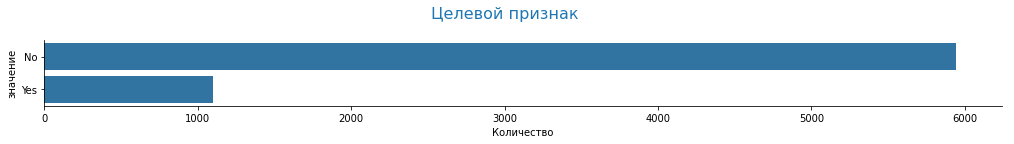

значение,No,Yes
Количество,84.37%,15.63%


In [12]:
show_cat(
    df_contract, y="target", 
    suptitle="Целевой признак",
    xlabel="Количество", ylabel="значение"
)

Клиенты, которые расторгли договор составляют 15.63% от датасета. Это говорит о наличии дисбаланса классов в датасете.

#### Дата заключения договора

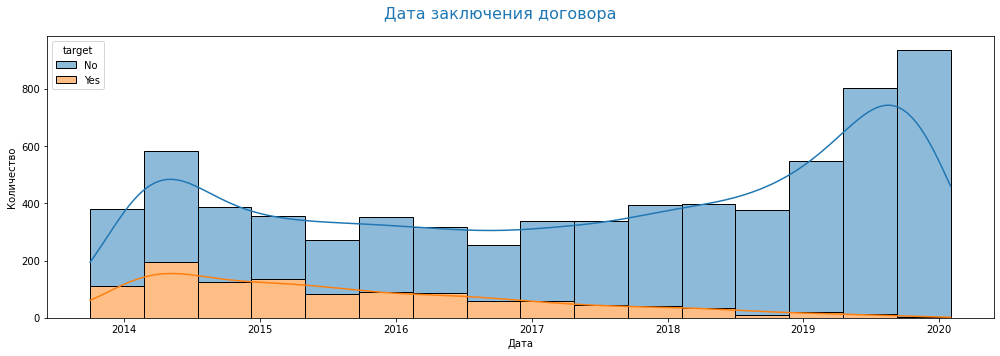

,count,mean,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
target,,,,,,,,,,,,,
No,"5,942",2017-08-21 07:39:14.358801664,2013-10-01 00:00:00,2014-02-01 00:00:00,2014-02-01 00:00:00,2015-12-01 00:00:00,2018-03-01 00:00:00,2019-06-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,Probably NOT,0.00
Yes,"1,101",2015-08-30 21:37:26.321526016,2013-12-01 00:00:00,2013-12-14 07:55:12,2014-02-01 00:00:00,2014-06-01 00:00:00,2015-05-01 00:00:00,2016-08-01 00:00:00,2019-06-01 00:00:00,2019-08-18 16:04:47.999999744,2019-10-01 00:00:00,Probably NOT,0.00


In [13]:
show_num(
    df_contract, x="BeginDate", hue="target",
    suptitle="Дата заключения договора", 
    xlabel="Дата", ylabel="Количество", boxplot=False
)

Имеются данные по договорам с 1 октября 2013 года, а последние начали свое действие в дату выгрузки 1 февраля 2020 года. По графику заметно значительное увеличение новых контрактов с 2019 года. Судя по всему датой устанавливается первый день месяца. Довольно большое количество целевых клиентов заключили договор в период с начала 2014 по середину 2016 годов.

#### Дата расторжения и срок действия договора

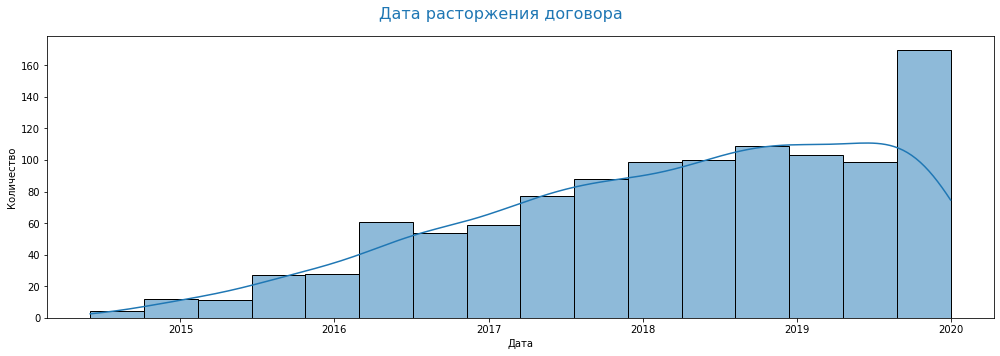

,count,mean,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
Дата,"1,101",2018-03-12 18:21:15.204359680,2014-06-01 00:00:00,2014-09-01 00:00:00,2015-01-01 00:00:00,2017-05-01 00:00:00,2018-06-01 00:00:00,2019-04-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,Probably NOT,0.00


In [14]:
show_num(
    df_contract.query("target == 'Yes'"), x="EndDate", 
    suptitle="Дата расторжения договора", 
    xlabel="Дата", ylabel="Количество", boxplot=False
)

Ближе к 2020 году заметен рост оттока клиентов. Оценим сроки действия договоров.

In [15]:
print("Уникальные значения дня:", df_contract["EndDate"].dt.day.unique())

Уникальные значения дня: [1]


Очевидно, что данные по окончанию договора также приходятся на первое число месяца. Добавим признак длительности договора путем рассчета разницы между датой окончания и датой начала действия договора.

In [16]:
df_contract["DayCount"] = (df_contract["EndDate"] - df_contract["BeginDate"]).dt.days
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,DayCount
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,No,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,No,153
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.2,No,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.4,No,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.6,No,337
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.8,No,215


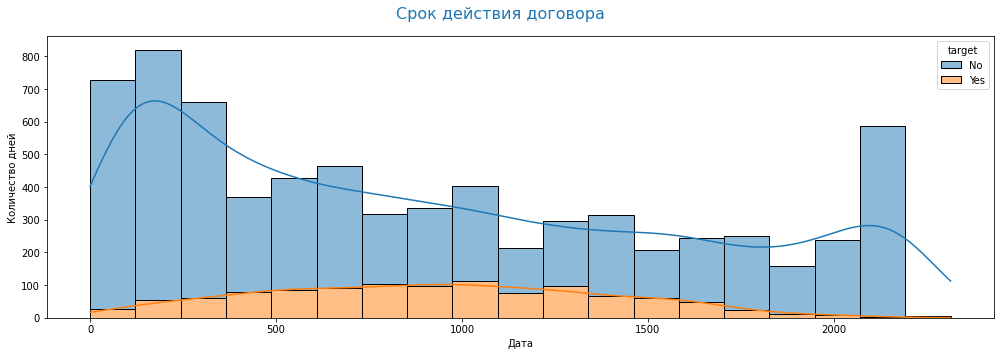

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
target,,,,,,,,,,,,,,
No,"5,942.00",893.68,716.96,0.00,0.00,31.00,245.00,702.00,"1,523.00","2,191.00","2,191.00","2,314.00",Probably NOT,0.00
Yes,"1,101.00",924.86,458.77,28.00,30.43,61.00,577.00,915.00,"1,249.00","1,948.00","2,069.14","2,129.00",Probably NOT,0.00


In [17]:
show_num(
    df_contract, x="DayCount", hue="target",
    suptitle="Срок действия договора", 
    xlabel="Дата", ylabel="Количество дней", boxplot=False
)

По сроку действия договора можно отметить, что половина клиентов, которые расторгли договор приходится на срок в пределах от 277 до 1249 дней. Медиана приходится на значение в 915 дней. Максимальное значение - 1948 дней. При этом остальные клиенты имеют больший разброс по значениям, в том числе более длительные сроки действия договоров.

#### Тип оплаты

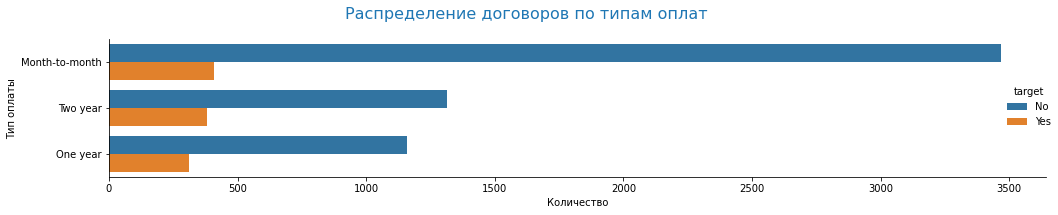

Тип оплаты,Month-to-month,Two year,One year
target,,,
No,58.36%,22.11%,19.52%
Yes,36.97%,34.60%,28.43%


In [18]:
show_cat(
    df_contract, y="Type", hue="target", figsize=(14, 3),
    order=df_contract["Type"].value_counts().index.to_list(),
    suptitle="Распределение договоров по типам оплат",
    xlabel="Количество", ylabel="Тип оплаты"
)

По типам оплаты можно отметить следующее:
1. Большинство клиентов оплачивают ежемесячно;
2. Несмотря на то, что наибольшее количество расторгнувших договор приходится на клиентов с ежемесячным типом оплаты, соотношение клиентов с таким типом оплаты целевой группы клиентов к остальным клиентам наименьшее, что говорит о достаточно высоком оттоке клиентов с дугими типами оплаты.

#### Электронный рассчетный лист

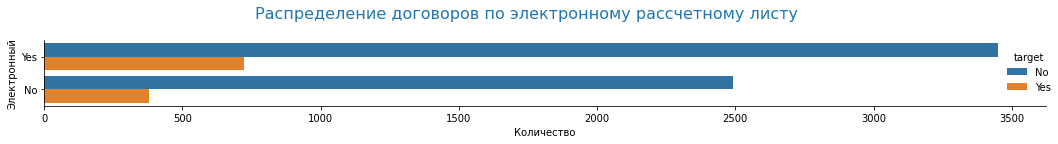

Электронный,Yes,No
target,,
No,58.06%,41.94%
Yes,65.49%,34.51%


In [19]:
show_cat(
    df_contract, y="PaperlessBilling", hue="target", 
    order=df_contract["PaperlessBilling"].value_counts().index.to_list(),
    suptitle="Распределение договоров по электронному рассчетному листу",
    xlabel="Количество", ylabel="Электронный"
)

Получающих электронный рассчетный лист больше. При этом процент ушедших немного выше среди таких клиентов.

#### Тип платежа

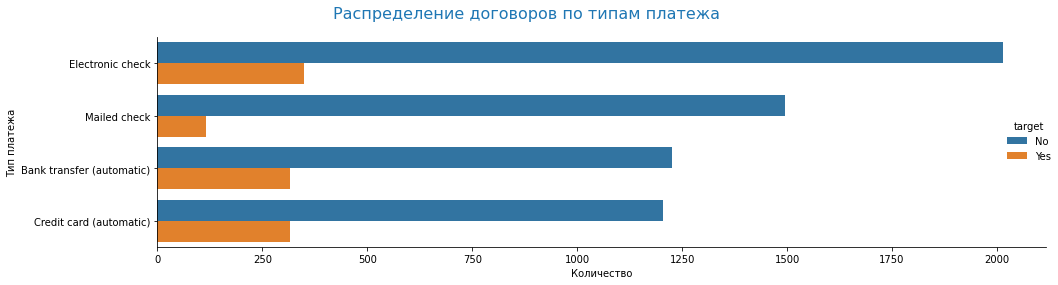

Тип платежа,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic)
target,,,,
No,33.91%,25.16%,20.65%,20.28%
Yes,31.79%,10.63%,28.79%,28.79%


In [20]:
show_cat(
    df_contract, y="PaymentMethod", hue="target", figsize=(14, 4),
    order=df_contract["PaymentMethod"].value_counts().index.to_list(),
    suptitle="Распределение договоров по типам платежа",
    xlabel="Количество", ylabel="Тип платежа"
)

Можно отметить, что наименьшее количество расторгнувших договор имеют тип платежа `Mailed check`.

#### Расходы за месяц

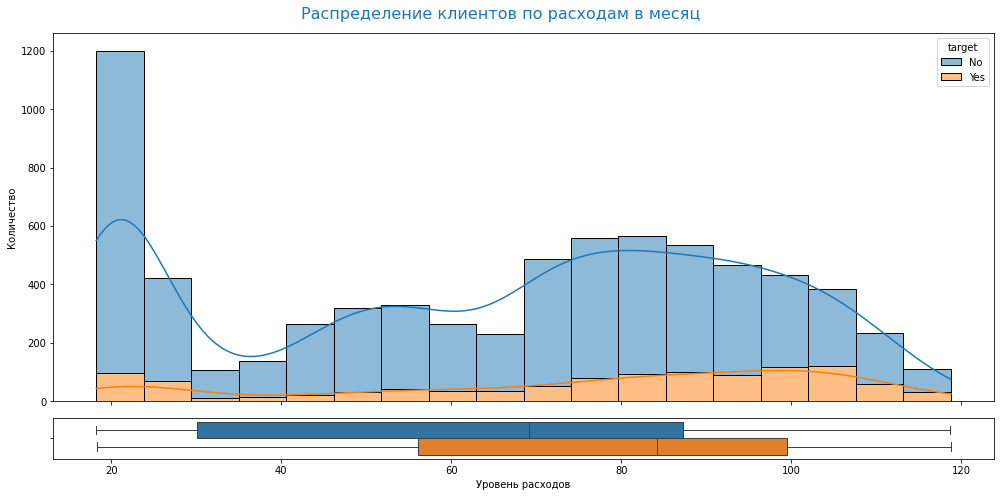

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
target,,,,,,,,,,,,,,
No,"5,942.00",62.76,29.84,18.25,18.80,19.15,30.06,69.20,87.24,114.41,116.88,118.60,Probably NOT,0.00
Yes,"1,101.00",75.55,29.12,18.40,18.82,19.40,56.15,84.20,99.50,115.55,118.52,118.75,Probably NOT,0.00


In [21]:
show_num(
    df_contract, x="MonthlyCharges", hue="target", figsize=(14, 7),
    suptitle="Распределение клиентов по расходам в месяц",
    xlabel="Уровень расходов", ylabel="Количество"
)

По расходам за месяц можно заметить три группы клиентов - с минимальными месячными расходами до 30-35, со средними месячными расходами около 50, а также с высокими месячными расходами более 70.

Довольно большое количество ушедших клиентов приходится на группу с наибольшими расходами - у 50% таких клиентов уровень расходов 84.2 и выше.

#### Общие расходы

Приведем тип данных к численному.

In [22]:
df_contract["TotalCharges"] = pd.to_numeric(df_contract["TotalCharges"], errors="coerce")
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   object        
 9   DayCount          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 550.4+ KB


После преобразования появились пропуски в значении общих расходов, проверим такие данные.

In [23]:
df_contract[df_contract["TotalCharges"].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,DayCount
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,No,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,No,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,No,0


По всем договорам с пропущенными значениями дата начала действия договора приходится на дату выгрузки, вероятнее всего еще не было оплаты для рассчета общих расходов. Заменим пропущенные значения нулями.

In [24]:
df_contract.loc[df_contract["TotalCharges"].isna(), "TotalCharges"] = 0
df_contract[df_contract["TotalCharges"] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,DayCount
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,No,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,No,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,No,0


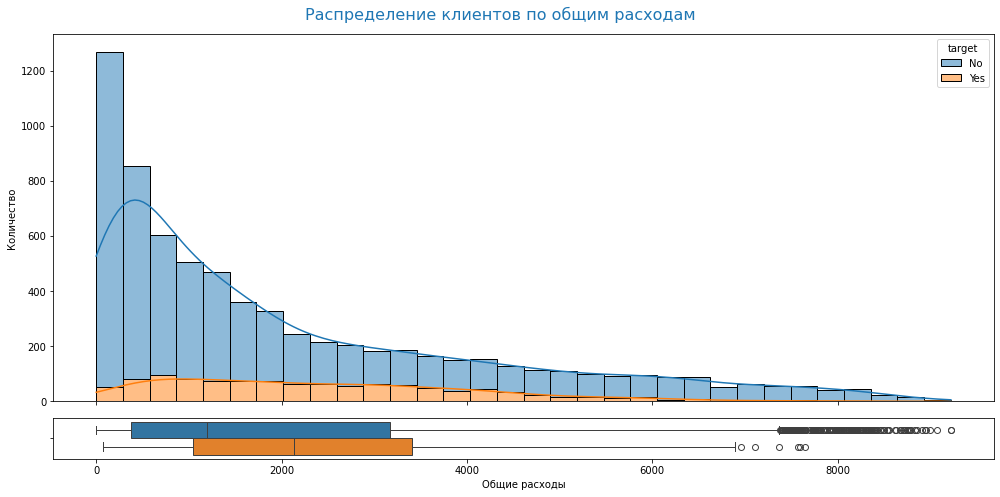

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
target,,,,,,,,,,,,,,
No,"5,942.00","2,067.87","2,193.90",0.00,0.00,20.38,374.35,"1,192.80","3,173.84","8,215.42","8,841.74","9,221.38",Probably NOT,0.00
Yes,"1,101.00","2,371.38","1,581.86",77.84,83.56,141.50,"1,048.05","2,139.03","3,404.91","6,471.63","7,583.16","7,649.76",Probably NOT,0.00


In [25]:
show_num(
    df_contract, x="TotalCharges", hue="target", figsize=(14, 7),
    suptitle="Распределение клиентов по общим расходам",
    xlabel="Общие расходы", ylabel="Количество"
)

По общим расходам значения целевые клиенты сдвинуты также к более высоким значениям, в отличие от продолжающих пользоваться услугами клиентов. Средние значения общих расходов целевой группы составляет 2139, что практически на 80% выше средних расходов остальных пользователей.

Сравним произведение месячных расходов на количество месяцев с общими расходами клиентов.

In [26]:
df_contract["MonthCount"] = (
    df_contract["EndDate"].dt.year - df_contract["BeginDate"].dt.year
)*12 + df_contract["EndDate"].dt.month - df_contract["BeginDate"].dt.month

print("Количество расхождений общих расходов с месячными:",
    (
        round(
            (df_contract["MonthlyCharges"] * df_contract["MonthCount"]) - df_contract["TotalCharges"], 
            2) != 0
    ).sum()
)

Количество расхождений общих расходов с месячными: 3562


У более половины договоров из датасета имеются расхождения между текущими расходами за месяц и количеством месяцев действия договоров. Это можно попробовать объяснить следующими причинами:
1. Клиент менял состав услуг в течение действия договора;
2. Менялись тарифы на услуги;
3. Клиенту производили перерасчет услуг по различным причинам.

Если клиент производил смену состава услуг незадолго до расторжения договора, последние значения текущих расходов могут достаточно сильно отличаться от среднемесячных расходов за предыдущий период. Добавим новый признак - отношение текущих расходов за месяц к средним расходам за весь период действия договора и оценим распределение значений такого признака.

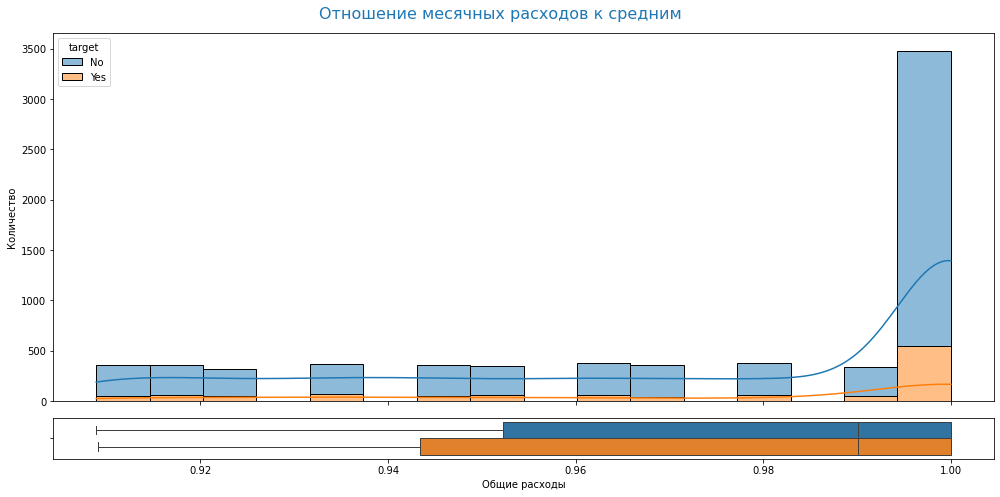

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
target,,,,,,,,,,,,,,
No,"5,942.00",0.97,0.03,0.91,0.91,0.91,0.95,0.99,1.00,1.00,1.00,1.00,Probably NOT,0.00
Yes,"1,101.00",0.97,0.03,0.91,0.91,0.91,0.94,0.99,1.00,1.00,1.00,1.00,Probably NOT,0.00


In [27]:
df_contract["ChargesRatio"] = df_contract.apply(
    lambda x:
    x["MonthlyCharges"] / x["TotalCharges"] * x["MonthCount"]
    if x["TotalCharges"] != 0 else 1,
    axis=1
)
show_num(
    df_contract, x="ChargesRatio", hue="target", figsize=(14, 7),
    suptitle="Отношение месячных расходов к средним",
    xlabel="Общие расходы", ylabel="Количество"
)

Судя по всему месячные расходы имеются только ниже средних месячных, либо клиенты только уменьшали состав услуг, либо имеются какие-то другие причины более высоких значений средних месячных расходов, например дополнительная оплата сверх лимита услуг. На данный факт лучше обратить внимание Заказчика.

В целом распределение выборки выглядит достаточно близким, однако для целевой группы общая масса имеет больший сдвиг к меньшим значениям отношения месячных расходов к средним фактическим за месяц.

### Персональные данные клиента

#### Пол

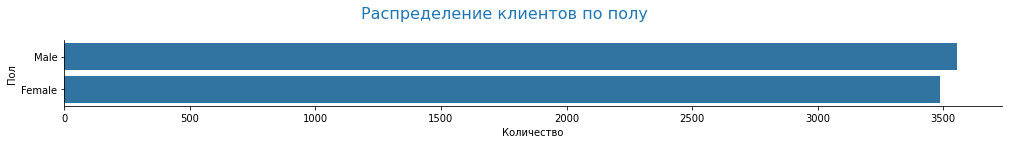

Пол,Male,Female
Количество,50.48%,49.52%


In [28]:
show_cat(
    df_personal, y="gender", 
    order=df_personal["gender"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по полу",
    xlabel="Количество", ylabel="Пол"
)

Датасет содержит близкое соотношение клиентов по полу.

#### Признак пенсионера

Признак пенсионера представлен числовыми значениями `0` или `1`, для удосбтва преобразуем к единому формату значения признака - `Yes`/`No` как для других признаков.

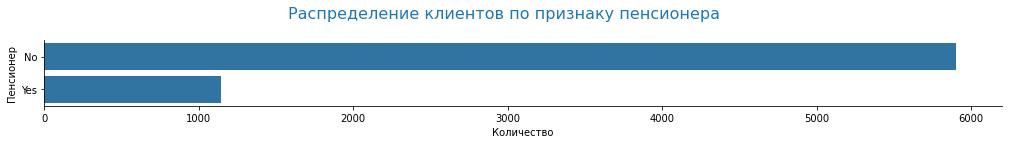

Пенсионер,No,Yes
Количество,83.79%,16.21%


In [29]:
df_personal["SeniorCitizen"] = df_personal["SeniorCitizen"].apply(
    lambda x: "No" if x == 0 else "Yes"
)
show_cat(
    df_personal["SeniorCitizen"].astype(str).to_frame(), y="SeniorCitizen", 
    suptitle="Распределение клиентов по признаку пенсионера",
    xlabel="Количество", ylabel="Пенсионер"
)

Пенсионеры среди клиентов составляю порядка 16% датасета.

#### Наличие супруга

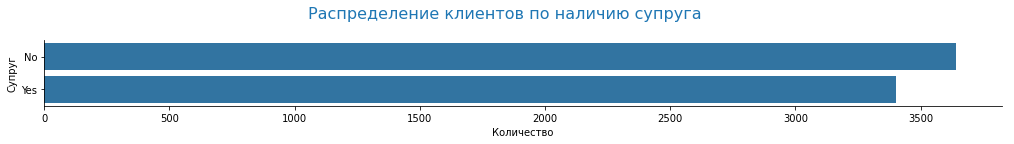

Супруг,No,Yes
Количество,51.70%,48.30%


In [30]:
show_cat(
    df_personal, y="Partner", 
    order=df_personal["Partner"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по наличию супруга",
    xlabel="Количество", ylabel="Супруг"
)

Распределение достаточно близкое с небольшим преимуществом у клиентов без супруга.

#### Наличие детей

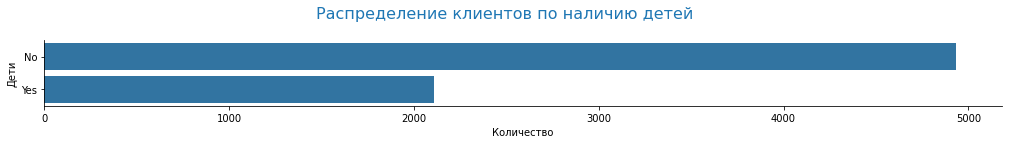

Дети,No,Yes
Количество,70.04%,29.96%


In [31]:
show_cat(
    df_personal, y="Dependents", 
    suptitle="Распределение клиентов по наличию детей",
    xlabel="Количество", ylabel="Дети"
)

Большая часть клиентов порядка 70% не имеют детей.

### Интернет-услуги

#### Тип подключения

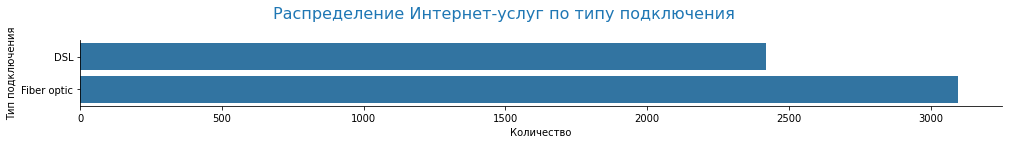

Тип подключения,DSL,Fiber optic
Количество,43.88%,56.12%


In [32]:
show_cat(
    df_internet, y="InternetService", 
    suptitle="Распределение Интернет-услуг по типу подключения",
    xlabel="Количество", ylabel="Тип подключения"
)

Среди клиентов Интернет-услуг имеется небольшое преобладание подключений по оптике.

#### Блокировка опасных сайтов

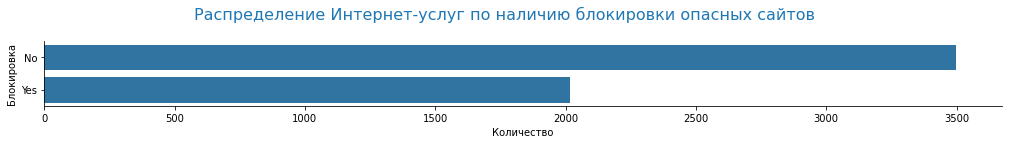

Блокировка,No,Yes
Количество,63.40%,36.60%


In [33]:
show_cat(
    df_internet, y="OnlineSecurity", 
    suptitle="Распределение Интернет-услуг по наличию блокировки опасных сайтов",
    xlabel="Количество", ylabel="Блокировка"
)

Большая часть пользователей Интернет-услуг не пользуется услугой блокировки опасных сайтов, используют такие услуги 36.6%.

#### Облачное хранилище файлов для резервного копирования данных

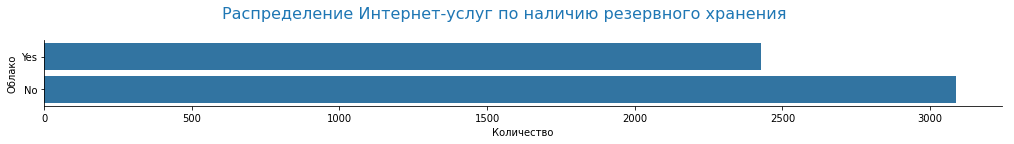

Облако,Yes,No
Количество,44.03%,55.97%


In [34]:
show_cat(
    df_internet, y="OnlineBackup", 
    suptitle="Распределение Интернет-услуг по наличию резервного хранения",
    xlabel="Количество", ylabel="Облако"
)

Данная услуга более популярна, ей пользуются около 44% пользователей Интернет-услуг.

#### Антивирус

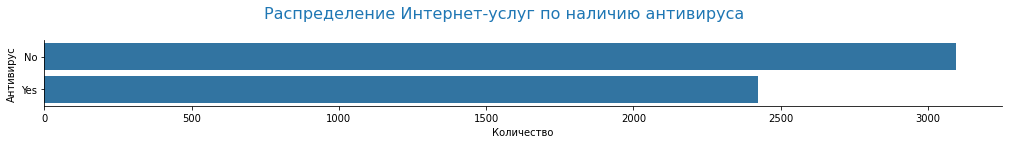

Антивирус,No,Yes
Количество,56.10%,43.90%


In [35]:
show_cat(
    df_internet, y="DeviceProtection", 
    suptitle="Распределение Интернет-услуг по наличию антивируса",
    xlabel="Количество", ylabel="Антивирус"
)

Антивирусом пользуются менее 44% пользователей.

#### Выделенная линия технической поддержки

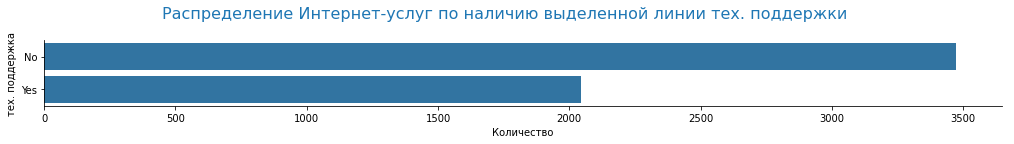

тех. поддержка,No,Yes
Количество,62.95%,37.05%


In [36]:
show_cat(
    df_internet, y="TechSupport", 
    suptitle="Распределение Интернет-услуг по наличию выделенной линии тех. поддержки",
    xlabel="Количество", ylabel="тех. поддержка"
)

Услуги выделенной линии технической поддержки также не пользуются большим спросом - ей пользуется немного больше 37% пользователей Интернет-услуг.

#### Стриминговое телевидение

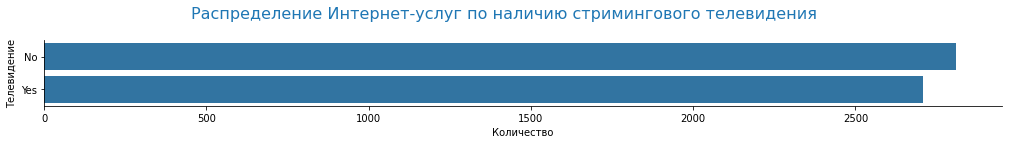

Телевидение,No,Yes
Количество,50.93%,49.07%


In [37]:
show_cat(
    df_internet, y="StreamingTV", 
    suptitle="Распределение Интернет-услуг по наличию стримингового телевидения",
    xlabel="Количество", ylabel="Телевидение"
)

Стриминговое телевидение еще более популярная услуга, ей пользуются порядка 49% пользователей Интернет-услуг.

#### Каталог фильмов

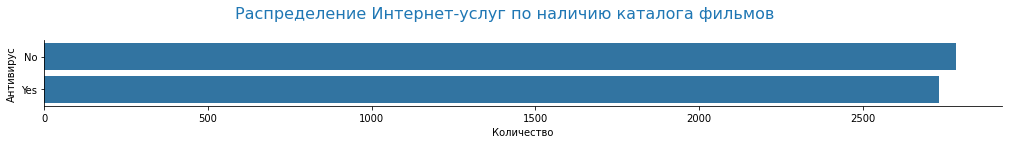

Антивирус,No,Yes
Количество,50.48%,49.52%


In [38]:
show_cat(
    df_internet, y="StreamingMovies", 
    suptitle="Распределение Интернет-услуг по наличию каталога фильмов",
    xlabel="Количество", ylabel="Антивирус"
)

Каталог фильмов - наиболее популярная дополнитеьная услуга, ей пользуются 49.5% пользователей Интернет-услуг.

### Услуги телефонии

Датасет содержит только один дополнительный признак - наличие нескольких линий.

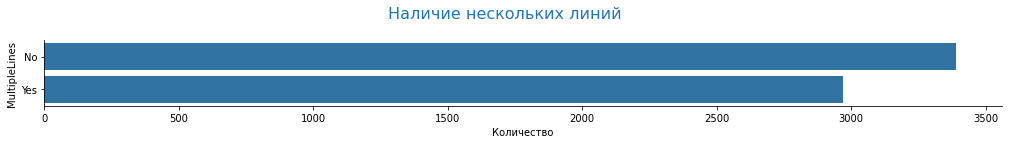

,No,Yes
Количество,53.29%,46.71%


In [39]:
show_cat(
    df_phone, y="MultipleLines", 
    suptitle="Наличие нескольких линий",
    xlabel="Количество", 
)

Несколькими линиями пользуется 46.7% пользователей услуг телефонии.

### ID клиента

In [40]:
print("Количество дубликатов ID по договорам:", df_contract["customerID"].duplicated().sum())
print("Количество дубликатов ID по клиентам:", df_personal["customerID"].duplicated().sum())
print("Количество дубликатов ID по Интернет-услугам:", df_internet["customerID"].duplicated().sum())
print("Количество дубликатов ID по услугам телефонии:", df_internet["customerID"].duplicated().sum())

Количество дубликатов ID по договорам: 0
Количество дубликатов ID по клиентам: 0
Количество дубликатов ID по Интернет-услугам: 0
Количество дубликатов ID по услугам телефонии: 0


Дубликаты по ID клиента отсутствуют во всех датасетах. Можно перейти к объединению данных.

### Промежуточные итоги

Произведен исследовательский анализ датасетов и предобработка данных:
1. Добавлен целевой признак на основе наличия даты окончания договора. Датасет содержит всего порядка 15% договоров с целевыми клиентами, что говорит о дисбалансе классов;
2. Добавлен новый признак срока действия договора;
3. Выявлены пропуски значений по числовому признаку общих расходов, которые имеются только по новым договорам, действующим менее месяца. Такие пропуски заменены на `0`;
4. Добавлен признак отношения текущего значения расходов за месяц к среднему значению месячных расходов (общие расходы / количество месяцев);
5. Признак пенсионера переведен из числового в категориальный по аналогии с другими категориальными признаками.

По остальным признакам аномалии не выявлены. Требуется дополнительное исследование датасетов в разрезе целевого признака.

## Объединение данных

In [41]:
data = df_contract.merge(df_personal, how="left", on="customerID")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   object        
 9   DayCount          7043 non-null   int64         
 10  MonthCount        7043 non-null   int64         
 11  ChargesRatio      7043 non-null   float64       
 12  gender            7043 non-null   object        
 13  SeniorCitizen     7043 non-null   object        
 14  Partner           7043 n

Пропуски отсутствуют, соответственно датасет с персональными данными клиента соответствует датасету с договорами. Добавим информацию об Интернет-услугах и телефонии.

In [42]:
data = data.merge(df_internet, how="left", on="customerID", )
data = data.merge(df_phone, how="left", on="customerID", )
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   object        
 9   DayCount          7043 non-null   int64         
 10  MonthCount        7043 non-null   int64         
 11  ChargesRatio      7043 non-null   float64       
 12  gender            7043 non-null   object        
 13  SeniorCitizen     7043 non-null   object        
 14  Partner           7043 n

Добавлены все признаки из датасета по Интернет-услугам - 5517, а также из датасета по услугам телефонии - 6361 запись. Появились пропуски, это говорит о том, что не все клиенты пользуются Интернет-услугами или услугами телефонии. Оценим нет ли клиентов, у которых отсутствуют оба вида услуг.

In [43]:
print(
    "Количество клиентов, у которых отсутствуют услуги:",
    (data["InternetService"].isna() & data["MultipleLines"].isna()).sum()
)


Количество клиентов, у которых отсутствуют услуги: 0


У всех клиентов имеется хотябы одна услуга. Заполним пропущенные значения заглушкой `None`, что будет обозначать отсутствие услуг по договору.

In [44]:
data = data.fillna("None")
data.sample(15, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,DayCount,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
6986,3976-BWUCK,2017-07-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),94.10,2917.10,No,945,...,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,No,Yes
17,9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51,No,2163,...,No,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes
6744,6500-JVEGC,2014-06-01,2020-02-01,One year,No,Bank transfer (automatic),101.35,6891.80,No,2071,...,No,No,Fiber optic,Yes,Yes,Yes,No,Yes,No,Yes
3056,0263-FJTQO,2015-12-01,2020-02-01,Two year,Yes,Credit card (automatic),70.50,3771.75,No,1523,...,Yes,Yes,DSL,Yes,No,No,Yes,Yes,No,Yes
5760,4583-PARNH,2018-10-01,2020-02-01,Month-to-month,Yes,Electronic check,91.55,1611.28,No,488,...,Yes,No,Fiber optic,No,No,Yes,Yes,No,Yes,No
2352,3981-QSVQI,2019-06-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),19.70,159.18,No,245,...,No,No,None,None,None,None,None,None,None,No
252,9514-JDSKI,2019-11-01,2020-02-01,Month-to-month,No,Electronic check,40.20,129.04,No,92,...,Yes,No,DSL,No,Yes,No,No,Yes,No,None
3239,3890-RTCMS,2018-10-01,2020-02-01,Month-to-month,Yes,Mailed check,49.45,791.20,No,488,...,No,No,DSL,No,No,No,Yes,No,No,No
1735,2040-XBAVJ,2014-02-01,2020-02-01,Two year,No,Bank transfer (automatic),114.45,8240.40,No,2191,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2809,4360-QRAVE,2017-01-01,2020-02-01,Month-to-month,No,Electronic check,36.65,1356.05,No,1126,...,No,No,DSL,No,Yes,Yes,No,No,No,None


### Промежуточные итоги

Произведено объединение датасетов, все строки датасета попали в объединенную выборку, соответственно в датасетах отсутствуют лишние данные. Также произведена проверка на наличие хотя бы одной услуги для каждого договора с клиентом - такие пропуски отсутствуют.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Персональные данные клиента

#### Пол

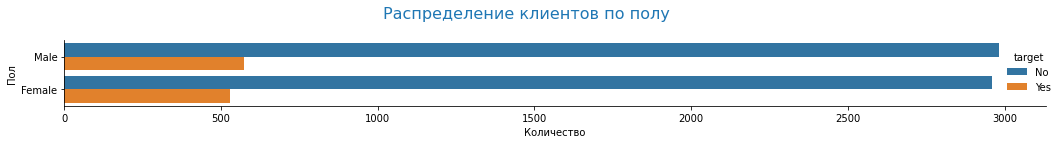

Пол,Male,Female
target,,
No,50.19%,49.81%
Yes,52.04%,47.96%


In [45]:
show_cat(
    data, y="gender", hue="target",
    order=data["gender"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по полу",
    xlabel="Количество", ylabel="Пол"
)

По целевым клиентам имеется незначительный сдвиг в сторону мужского пола.

#### Признак пенсионера

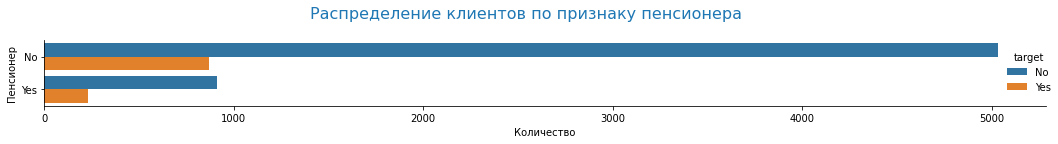

Пенсионер,No,Yes
target,,
No,84.69%,15.31%
Yes,78.93%,21.07%


In [46]:
show_cat(
    data, y="SeniorCitizen", hue="target",
    order=data["SeniorCitizen"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по признаку пенсионера",
    xlabel="Количество", ylabel="Пенсионер"
)

Целевые клиенты чаще являются пенсионерами - 21% пенсионеров против 15.3% у продолжающих пользоваться услугами клиентов.

#### Наличие супруга

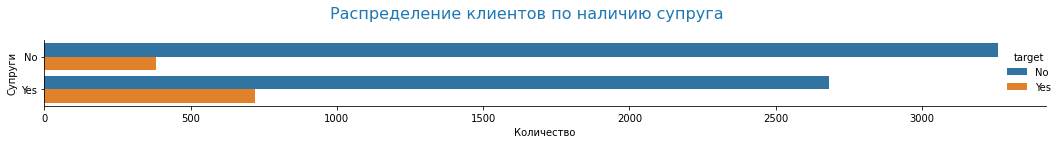

Супруги,No,Yes
target,,
No,54.85%,45.15%
Yes,34.70%,65.30%


In [47]:
show_cat(
    data, y="Partner", hue="target",
    order=data["Partner"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по наличию супруга",
    xlabel="Количество", ylabel="Супруги"
)

Распределение целевых клиентов очень сильно отличается от оставшихся клиентов, среди них существенно больше семейных.

#### Наличие детей

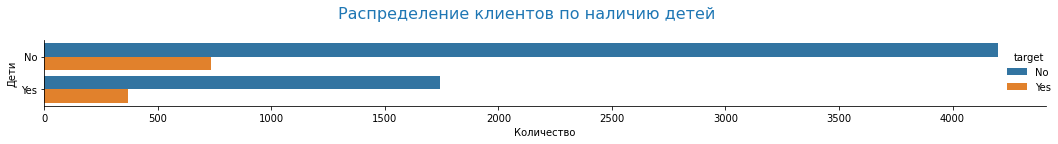

Дети,No,Yes
target,,
No,70.68%,29.32%
Yes,66.58%,33.42%


In [48]:
show_cat(
    data, y="Dependents", hue="target",
    order=data["Dependents"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по наличию детей",
    xlabel="Количество", ylabel="Дети"
)

По наличию детей соотношение довольно близкое, немного больше клиентов с детьми по целевой группе по сравнению с остальными клиентами.

### Интернет-услуги

#### Тип подключения

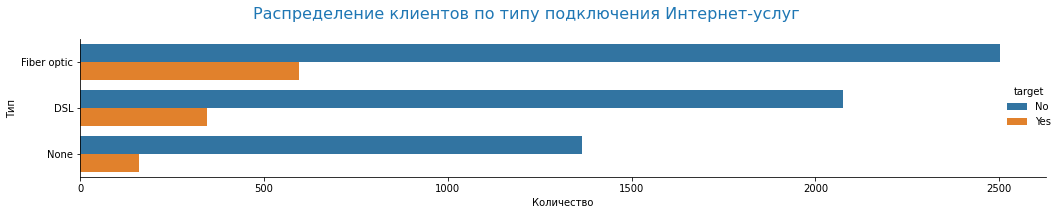

Тип,Fiber optic,DSL,None
target,,,
No,42.09%,34.92%,22.99%
Yes,54.04%,31.43%,14.53%


In [49]:
show_cat(
    data, y="InternetService", hue="target", figsize=(14, 3),
    order=data["InternetService"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по типу подключения Интернет-услуг",
    xlabel="Количество", ylabel="Тип"
)

Основная масса целевых пользователей являются пользователями Интернет-услуг, основную массу из которых составляют подключенные по оптоволокну.

#### Блокировка опасных сайтов

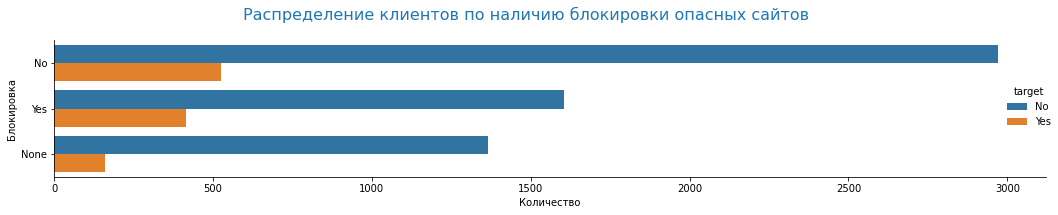

Блокировка,No,Yes,None
target,,,
No,50.02%,26.99%,22.99%
Yes,47.77%,37.69%,14.53%


In [50]:
show_cat(
    data, y="OnlineSecurity", hue="target", figsize=(14, 3),
    order=data["OnlineSecurity"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по наличию блокировки опасных сайтов",
    xlabel="Количество", ylabel="Блокировка"
)

Немалый процент целевых клиентов приходится на пользователей услуг блокировки опасных сайтов, по сравнению с остальными клиентами.

#### Облачное хранилище файлов для резервного копирования данных

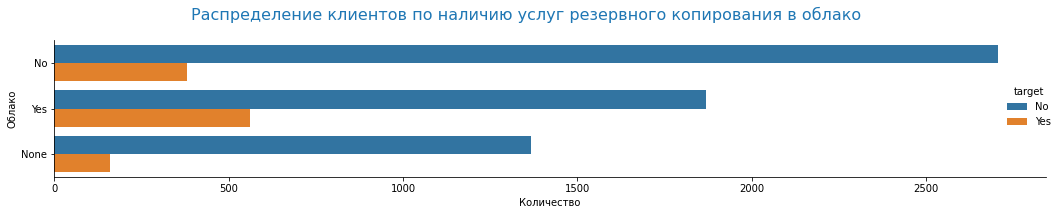

Облако,No,Yes,None
target,,,
No,45.56%,31.45%,22.99%
Yes,34.60%,50.86%,14.53%


In [51]:
show_cat(
    data, y="OnlineBackup", hue="target", figsize=(14, 3),
    order=data["OnlineBackup"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по наличию услуг резервного копирования в облако",
    xlabel="Количество", ylabel="Облако"
)

Довольно большой процент целевых клиентов приходится на пользователей услуг резервного копирования данных - более 50%.

#### Антивирус

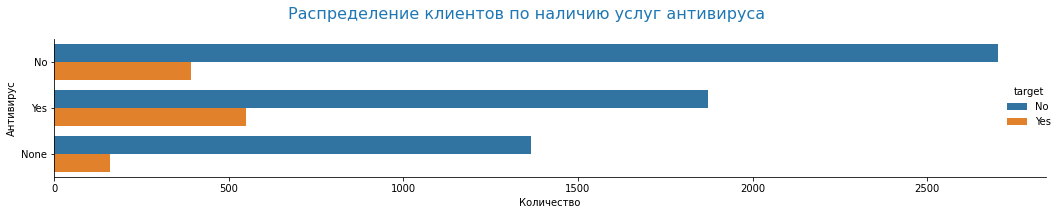

Антивирус,No,Yes,None
target,,,
No,45.51%,31.50%,22.99%
Yes,35.51%,49.95%,14.53%


In [52]:
show_cat(
    data, y="DeviceProtection", hue="target", figsize=(14, 3),
    order=data["DeviceProtection"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по наличию услуг антивируса",
    xlabel="Количество", ylabel="Антивирус"
)

По данному признаку также имеется довольно высокое количество целевых клиентов, пользующихся услугой - почти 50%.

#### Выделенная линия технической поддержки

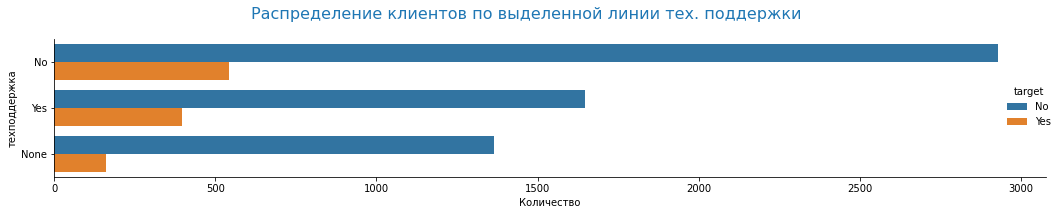

техподдержка,No,Yes,None
target,,,
No,49.31%,27.70%,22.99%
Yes,49.32%,36.15%,14.53%


In [53]:
show_cat(
    data, y="TechSupport", hue="target", figsize=(14, 3),
    order=data["TechSupport"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по выделенной линии тех. поддержки",
    xlabel="Количество", ylabel="техподдержка"
)

По пользователем выделенной линии техподдержки также имеется небольшой сдвиг целевых клиентов к использующим данную услуг.

#### Стриминговое телевидение

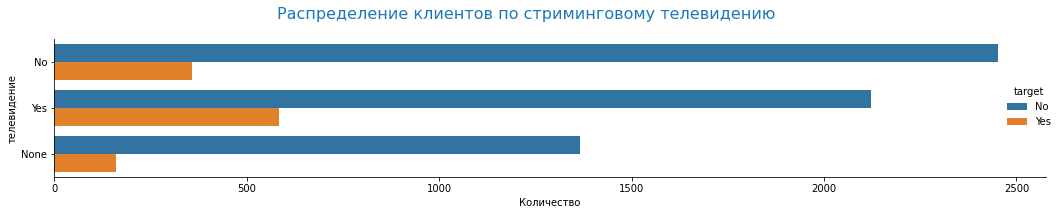

телевидение,No,Yes,None
target,,,
No,41.28%,35.73%,22.99%
Yes,32.43%,53.04%,14.53%


In [54]:
show_cat(
    data, y="StreamingTV", hue="target", figsize=(14, 3),
    order=data["StreamingTV"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по стриминговому телевидению",
    xlabel="Количество", ylabel="телевидение"
)

По данному признаку также существенно большее преобладание пользователей стримингового телевидения в целевой группе клиентов - около 53%.

#### Каталог фильмов

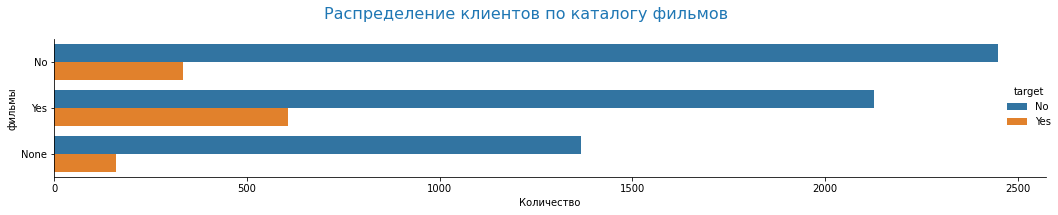

фильмы,No,Yes,None
target,,,
No,41.23%,35.78%,22.99%
Yes,30.43%,55.04%,14.53%


In [55]:
show_cat(
    data, y="StreamingMovies", hue="target", figsize=(14, 3),
    order=data["StreamingMovies"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по каталогу фильмов",
    xlabel="Количество", ylabel="фильмы"
)

Еще большее преобладание пользователей каталога фильмов в целевой группе клиентов - более 55%

### Услуги телефонии

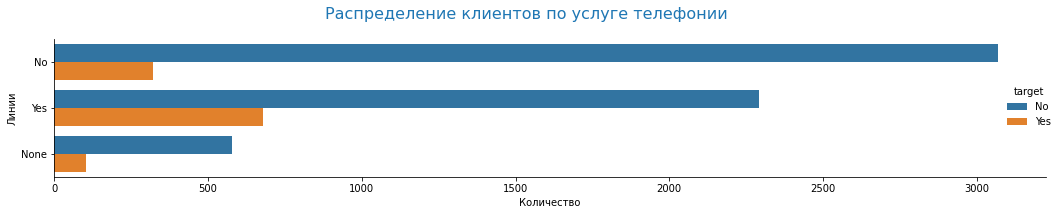

Линии,No,Yes,None
target,,,
No,51.67%,38.59%,9.74%
Yes,29.06%,61.58%,9.36%


In [56]:
show_cat(
    data, y="MultipleLines", hue="target", figsize=(14, 3),
    order=data["MultipleLines"].value_counts().index.to_list(),
    suptitle="Распределение клиентов по услуге телефонии",
    xlabel="Количество", ylabel="Линии"
)

Судя по всему, среди целевой группы довольно малое количество клиентов без услуг телефонии - 9.4%, соответственно большинство таких клиентов пользуются как услугами телефонии, так и Интернет-услугами. Причем по услугам телефонии такие клиенты преимущественно имеют несколько телефонных линий - 61.6%.

### Корреляция признаков

Оценку корреляции произведем без признаков ID клиента и дат, так как данные признаки будут исключены из датасета для избежания утечки целевого признака.

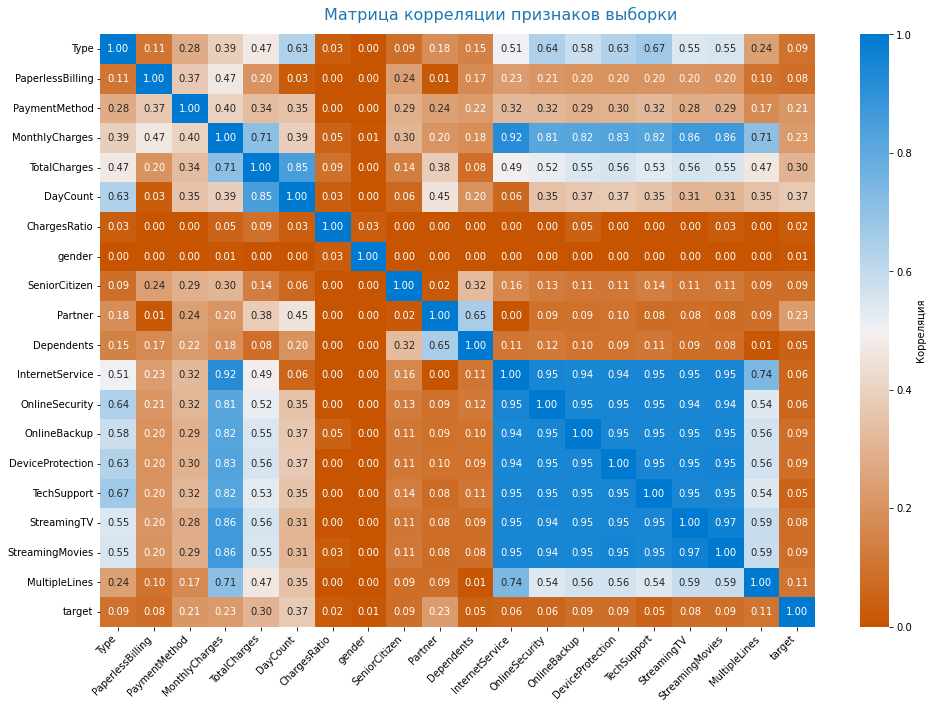

In [57]:
# Список столбцов для дальнейшей работы
data_cols = data.drop(columns=["customerID", "BeginDate", "EndDate", "MonthCount"]).columns.to_list()
# Перенос target в конец списка
data_cols.append(data_cols.pop(data_cols.index("target")))
# Числовые признаки
num_cols = data[data_cols[:-1]].select_dtypes(exclude="object").columns.to_list()
# Категориальные признаки
cat_cols = data[data_cols[:-1]].select_dtypes(include="object").columns.to_list()

# Вывод матрицы корреляции
plt.figure(figsize=(14, 10))
sns.heatmap(
    (
        data[data_cols].phik_matrix(
            interval_cols=num_cols
        )
    ), 
    annot=True, fmt=".2f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Матрица корреляции признаков выборки", show=True)

Корреляция целевого признака с остальными признаками выборки довольно низкая - умеренная корреляция наблюдается с признаком длительности договора 0.37, слабая корреляция с признаком общих расходов 0.3, месячными расходами и наличием детей по 0.23, а также методом оплаты 0.21 и телефонией 0.11. С остальными признаками корреляция практически не наблюдается.

В части мультиколлинеарности можно отметить очень высокую корреляцию между принаками, которые относятся к Интернет-услугам  - 0.95-0.94. Высокая корреляция месячных затрат с Интернет-услугами - 0.92-0.81 и услугами телефонии 0.71, между признаками общих расходов и длительностью договора - 0.85, признаком услуг телефонии и типом подключения Интернет-услуг 0.74, а также месячных затрат с общими затратами - 0.71. Заметная корреляция типов оплаты с длительностью договора 0.63, а также Интернет-услугами и услугами телефонии - 0.67-0.55, между признаками наличия партнера и детей - 0.65. На границе умеренной корреляции признаки общих затрат с Интернет-услугами и телефонией - 0.56-0.47. Умеренная корреляция между признаками оплаты и расходов по большинству признаков. Наименьшая корреляция наблюдается для признака пола и нового признака отношения месячных затрат к средним со всеми остальными признаками датасета.

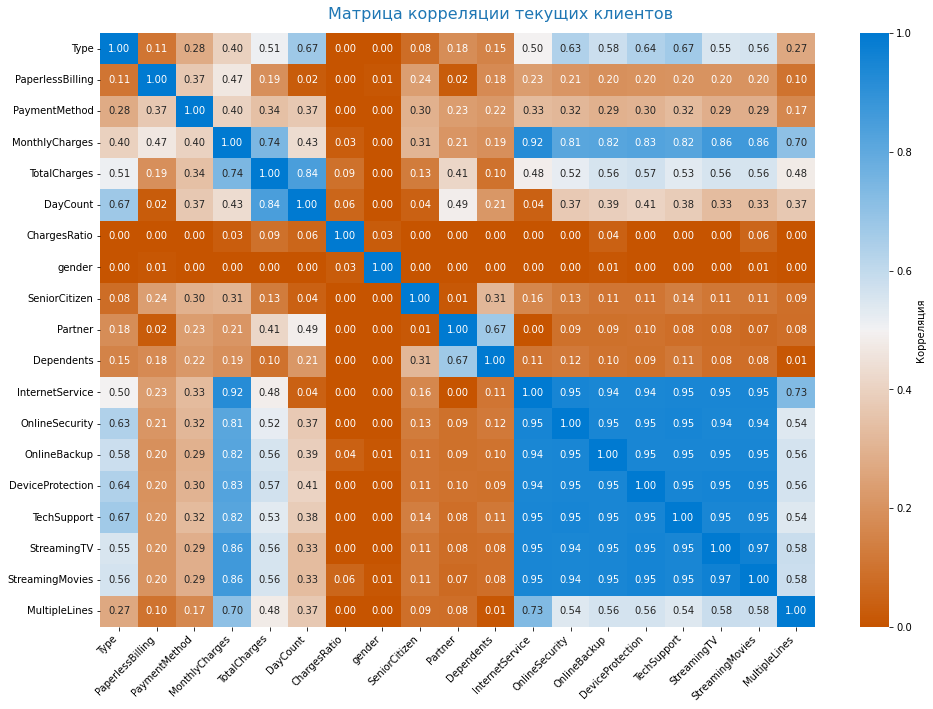

In [58]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    (
        data.query("target == 'No'")[data_cols[:-1]].phik_matrix(
            interval_cols=num_cols
        )
    ), 
    annot=True, fmt=".2f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Матрица корреляции текущих клиентов", show=True)

Для текущих клиентов немного увеличивается корреляция между признаками типа оплаты и длительностью договора, а также признаками наличия партнера и детей до 0.67, между признаками месячных и общих затрат до 0.74, а также наличием партнера и длительностью договора до 0.49. По остальным изменения незначительные и чаще всего в меньшую сторону.

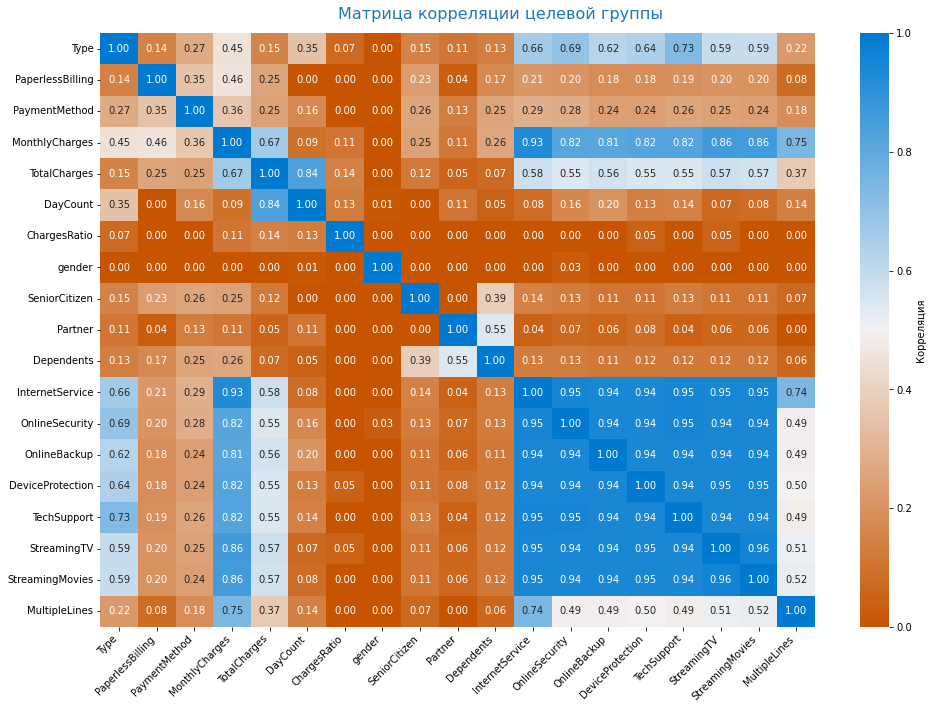

In [59]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    (
        data.query("target == 'Yes'")[data_cols[:-1]].phik_matrix(
            interval_cols=num_cols
        )
    ), 
    annot=True, fmt=".2f", cbar_kws={"label": "Корреляция"},
    cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
)
plt.xticks(rotation=45, ha="right")
add_plot_titles(suptitle="Матрица корреляции целевой группы", show=True)

Для целевой группы очень сильно снизилась корреляция между признаками типа оплаты и длительностью договора до 0.35, общими затратами до 0.15, а также между признаками наличия партнера и длительностью договора до 0.11. Корреляция также снизилась между признаками месячных и общих затрат до 0.67, между наличием партнера и наличием детей до 0.55 и в целом между большинством признаков типа оплаты и расходов. По остальным признакам снижение не такое существенное, а в части Интернет-услуг с некоторыми признаками корреляция немного увеличилась.

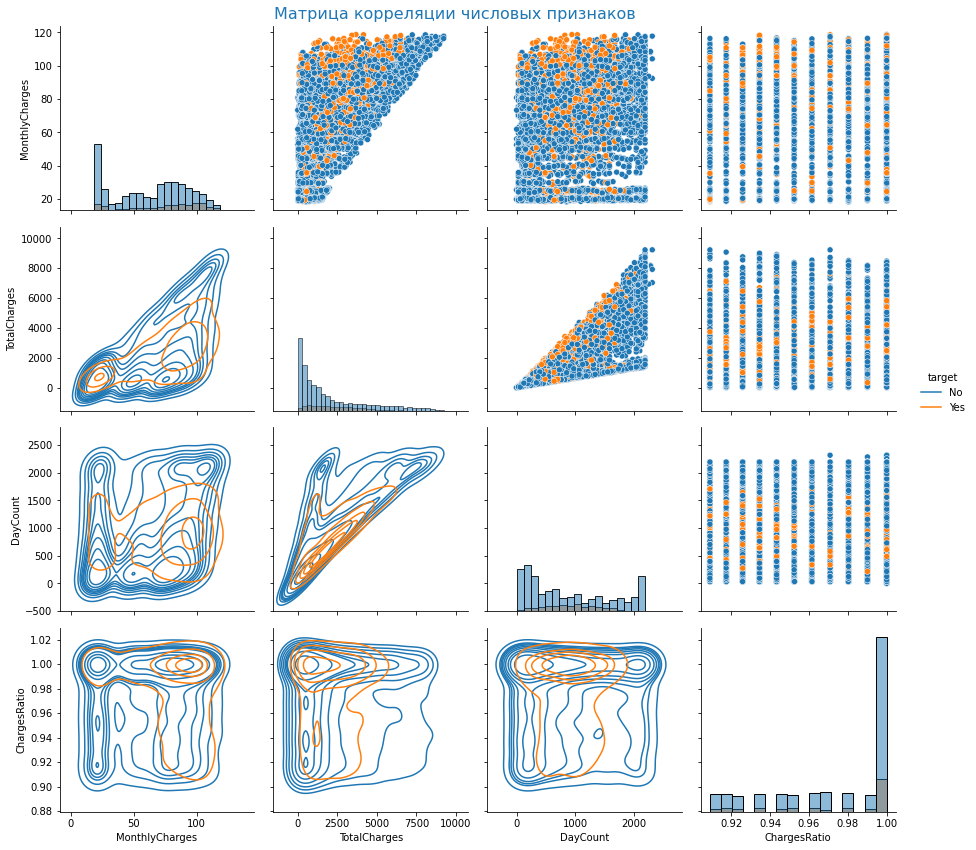

In [60]:
fig = sns.PairGrid(data[[*num_cols, "target"]], hue="target", height=3)
fig.map_diag(sns.histplot)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot)
fig.add_legend(loc='lower left', bbox_to_anchor=(1, 0.5))
add_plot_titles(suptitle="Матрица взаимосвязи числовых признаков", show=True)

По корреляции между признаками также наблюдается сдвиг целевой группы к более высоким значениям месячных и общих расходов. При этом можно выделить две подгруппы из целевой - большая группа имеет средние и высокие месячные расходы, другая подгруппа с низкими расходами существенно меньше. 

Можно отметить, что более низкое отношение месячных расходов к средним наблюдается для клиентов с различной длительностью действия договора, что может говорить  либо о наличии дополнительных расходов, либо все-таки клиенты в основном только снижают количество используемых услуг и могут делать это после непродолжительного времени использования услуг.

Дополнительно можно отметить, что из 3 групп по месячным затратам довольно непродолжительное существование у группы со средними затратами, что явно видно по графику длительность договора к месячным затратам, где в нижней части графика явно видны три подгруппы, а в верхней только две. Либо происходит более высокий отток по этой подгруппе, либо такая подгруппа сформировалась в последнее время.

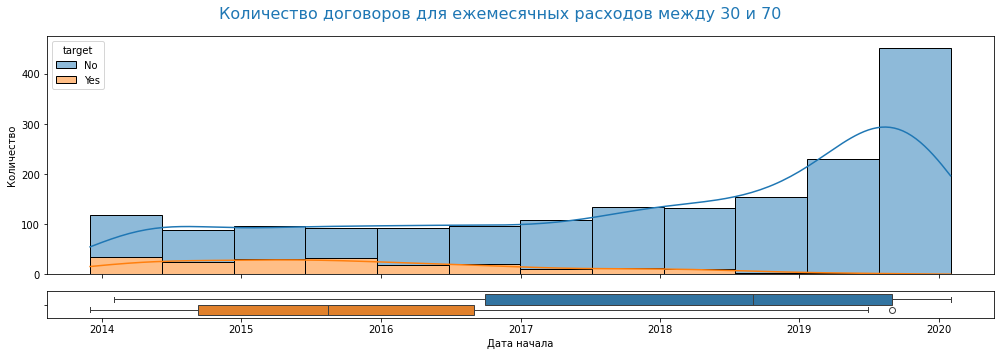

,count,mean,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
target,,,,,,,,,,,,,
No,"1,597",2018-01-20 09:44:17.733249536,2014-02-01 00:00:00,2014-02-01 00:00:00,2014-02-01 00:00:00,2016-10-01 00:00:00,2018-09-01 00:00:00,2019-09-01 00:00:00,2020-01-01 00:00:00,2020-01-29 16:20:55.680000256,2020-02-01 00:00:00,Probably NOT,0.00
Yes,202,2015-11-15 04:30:53.465346560,2013-12-01 00:00:00,2013-12-09 02:24:25.920000,2014-02-01 00:00:00,2014-09-08 12:00:00,2015-08-16 12:00:00,2016-09-01 00:00:00,2019-02-28 17:16:48,2019-08-15 19:11:08.160000,2019-09-01 00:00:00,Probably NOT,0.00


In [61]:
show_num(
    data.query("30 < MonthlyCharges < 70"), x="BeginDate", hue="target",
    suptitle="Количество договоров для ежемесячных расходов между 30 и 70",
    xlabel="Дата начала", ylabel="Количество"
)

Судя по графику для клиентов, месячные расходы которых между 30 и 70 рост количества таких договоров произошел в течение последнего времени и такая подгруппа в основном новые клиенты, которые раньше не настолько явно выделялись в отдельную подгруппу.

### Промежуточные итоги

Проведен исследовательский анализ объединенного датасета. По результатам проведенного исследования можно составить портрет целевого клиента:
1. Целевая группа клиентов это в основном не новые пользователи услуг, половина таких клиентов уходит по прошествии полутора лет и вплоть до более 4-х лет оказания услуг.
2. Часто такие клиенты пользуются как Интернет-услугами, так и услугами телефонии. При этом зачастую клиенты пользуются дополнительными Интернет-услугами - более 50% были подписаны на стриминговое телевидение и каталог фильмов, а также другие услуги но в меньшей пропорции, дополнительно такие клиенты чаще пользуются несколькими телефонными линиями. Соответственно целевая группа клиентов в среднем приносит больший доход Заказчику, чем основная масса клиентов - средний месячный расход составляет 84 против 69 для остальных клиентов, а средние общие расходы составляют порядка 2'139 против 1'192 для остальных клиентов. 
3. Целевая группа клиентов реже чем остальные клиенты использует ежемесячную оплату - большая часть клиентов имеет двухгодовую или годовую подписку, а также предпочитает электронные или автоматические типы платежа.
4. Это преимущественно семейные клиенты, хотя по наличию детей целевая группа не сильно отличается от остальных клиентов и чаще всего не имеет детей.

В части корреляции признаков можно отметить следующее:
1. Корреляция целевого признака с остальными довольно слабая;
2. Имеется мультиколлинеарность признаков Интернет-услуг, высокая корреляция услуг с расходами клиентов, а также умеренная корреляция между типами оплаты;

В части выбора моделей для машинного обучения можно отметить, что в виду слабой корреляции целевого признака с остальными, применение линейных моделей может быть не лучшим решением, однако оставим такую модель как базовую для сравнения других моделей. В виду наличия мультиколлинеарности в датасете будем использовать линейную модель с L2 регуляризацией.

В качестве основных выбраны ансамблевые модели на базе деревьев решений - бэггинговая модель RandomForest и в качестве наиболее перспективной бустинговая модель CatBoost в виду наличия большого количества категориальных признаков в датасете.

## Подготовка данных

Разделим датасет на тренировочную и тестовую выборки без признаков CustomerID, BeginDate и EndDate. Использование признака EndDate будет явной утечкой целевого признака, так как все значения ниже даты выгрузки будут целевыми. Также признак BeginDate может привести к утечке целевого признака в виду добавления признака длительности договора. Разделение датасета произведем со стратификацией выборки по целевому признаку.

In [62]:
data["target"] = data["target"].apply(lambda x: 0 if (x == "No") or (x == 0) else 1)
train, test = train_test_split(
    data[data_cols],
    stratify=data["target"], random_state=RANDOM_STATE
)
print("Размер тренировочной выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер тренировочной выборки: (5282, 20)
Размер тестовой выборки: (1761, 20)


Проверим наличие дубликатов в тренировочной выборке.

In [63]:
print("Дубликаты в разрезе значений целевого признака:")
train[train.duplicated()]["target"].value_counts()

Дубликаты в разрезе значений целевого признака:


0    2
Name: target, dtype: int64

Тренировочная выборка содержит 2 дубликата, которые не относятся к целевой группе клиентов. Удалим такие дубликаты, так как они не приносят моделям ценности, при этом незначительно снизят дисбаланс классов. Также выделим целевой признак.

In [64]:
# Удаление дубликатов
train.drop_duplicates(keep="first", inplace=True)
print("Новый размер тренировочной выборки:", train.shape)
# Разделение целевого признака
X_train = train.drop(columns="target")
y_train = train["target"]
X_test = test.drop(columns="target")
y_test = test["target"]

#del data, train, test
#gc.collect()

Новый размер тренировочной выборки: (5280, 20)


### Промежуточные итоги

Произведена подготовка данных - модели разделены на тренировочную и тестовую выборки. Из каждой выборки выделены целевой признак и признаки для обучения модели. Произведена очистка тренировочной выборки от дубликатов, так как они не приносят ценности моделям и при этом увеличивают дисбаланс классов.

## Обучение моделей машинного обучения

### Линейная модель

Для линейной модели все категориальные признаки закодируем посредством OneHotEncoder, а также в виду зависимости таких моделей от масштаба данных численные признаки масштабируем посредством StandardScaler.

In [65]:
ln_prep = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
], remainder="drop")

X_ln = ln_prep.fit_transform(X_train, y_train)
X_ln = pd.DataFrame(X_ln, columns=ln_prep.get_feature_names_out())
X_ln

,cat__Type_One year,cat__Type_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,cat__gender_Male,cat__SeniorCitizen_Yes,cat__Partner_Yes,cat__Dependents_Yes,...,cat__StreamingTV_None,cat__StreamingTV_Yes,cat__StreamingMovies_None,cat__StreamingMovies_Yes,cat__MultipleLines_None,cat__MultipleLines_Yes,num__MonthlyCharges,num__TotalCharges,num__DayCount,num__ChargesRatio
0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.505738,2.877727,1.893736,-0.095262
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,-1.512048,-0.823365,-0.516692,-1.792821
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,-0.672201,-0.864441,-1.052505,-2.057565
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.787180,-0.240475,0.419881,0.829813
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,-0.648872,0.073843,0.911656,0.829813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,-1.357076,-0.180126,1.893736,0.829813
5276,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,-1.355410,-0.958696,-1.142052,0.829813
5277,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,-1.495385,-0.426714,1.227272,-1.247996
5278,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.842525,-0.704465,-1.006998,0.829813


Произведем подбор гиперпараметров для модели с кросс-валидацией

In [66]:
# Переменная для результатов кросс-валидации
ln_cv_results = {
    "Метрика ROC-AUC": [],
    "Метрика Accuracy": [],
    "Время обучения": [],
    "Время предсказания": []
}

# Функция подбора гиперпараметров
def ln_optimize(trial):
    alpha = trial.suggest_float("alpha", 0.01, 100, log=True)
    
    pipeline = Pipeline([
        ("preprocessor", ln_prep),
        ("model", RidgeClassifier(alpha=alpha, class_weight="balanced"))
    ])
    
    cv_result = cross_validate(
        pipeline, X_train, y_train,
        cv=CV, n_jobs=-1, scoring=SCORING
    )
    
    ln_cv_results["Метрика ROC-AUC"].append(cv_result["test_roc_auc"].mean())
    ln_cv_results["Метрика Accuracy"].append(cv_result["test_accuracy"].mean())
    ln_cv_results["Время обучения"].append(cv_result["fit_time"].mean())
    ln_cv_results["Время предсказания"].append(cv_result["score_time"].mean())
    
    return cv_result["test_roc_auc"].mean()

# Подбор гиперпараметров
ln_study = optuna.create_study(
        direction="maximize", study_name="Ridge", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
ln_study.optimize(ln_optimize, n_trials=32, show_progress_bar=True)

  0%|          | 0/32 [00:00<?, ?it/s]

In [67]:
ln_cv_results = pd.DataFrame(ln_cv_results)

# Сохранение результатов для сравнения
model_cv_results = pd.DataFrame()
model_cv_results["Ridge"] = ln_cv_results.loc[ln_study.best_trial.number]

# Вывод результатов
print("Лучшие гиперпараметры:", ln_study.best_params)
print("Результаты кросс-валидации:")
ln_cv_results.loc[ln_study.best_trial.number]

Лучшие гиперпараметры: {'alpha': 6.463129037239502}
Результаты кросс-валидации:


Метрика ROC-AUC       0.755421
Метрика Accuracy      0.695455
Время обучения        0.195233
Время предсказания    0.177563
Name: 27, dtype: float64

Метрика ROC-AUC не доходит до ограничений проекта. Оценим важность признаков.

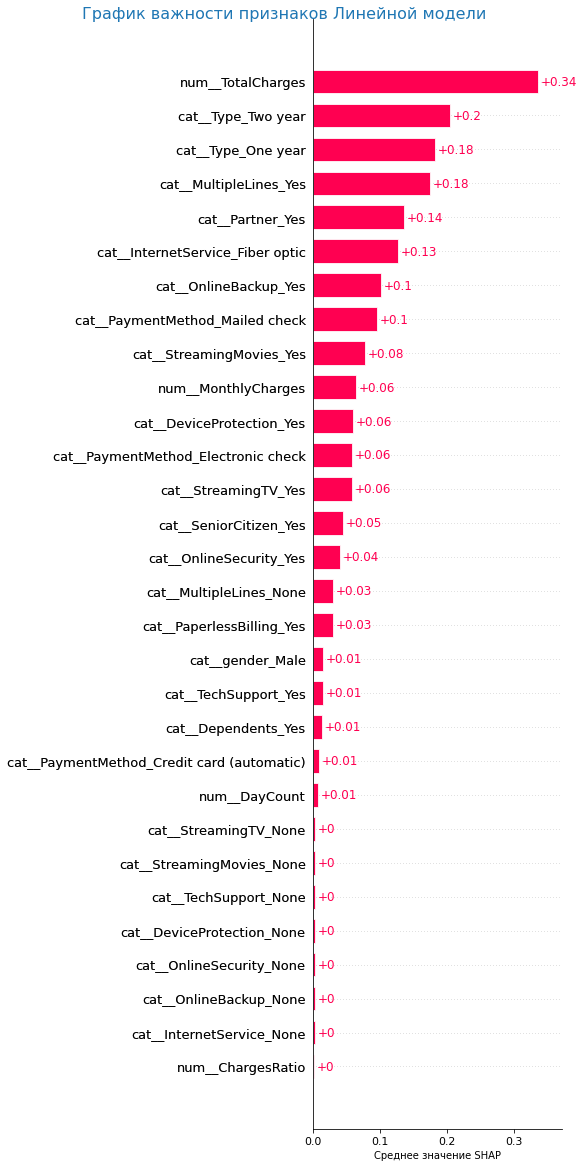

In [68]:
# Обучение модели
lr_model = RidgeClassifier(
    alpha=ln_study.best_params["alpha"], 
    class_weight="balanced"
)
lr_model.fit(X_ln, y_train)

# Получение
shap_explainer = shap.LinearExplainer(lr_model, X_ln)
shap_values = shap_explainer(X_ln)
shap.plots.bar(shap_values, max_display=30, show=False)
add_plot_titles(
    suptitle="График важности признаков Линейной модели", show=True,
    xlabel="Среднее значение SHAP"
)

Наиболее важными признаками для линейной модели является числовой признак общих расходов, после него с большим отрывом идут признаки типа оплаты - 2 года и год, также немаловажным признаком является наличие нескольких телефонных линий, наличие партнера и оптическое подключение интернета.

Наименее важными признаками для модели стал новый признак отношения затрат, а также отсутствие интернет сервисов. Количество дней действия договора также достаточно слабо влияет на результаты модели.

Оценим график влияния признаков.

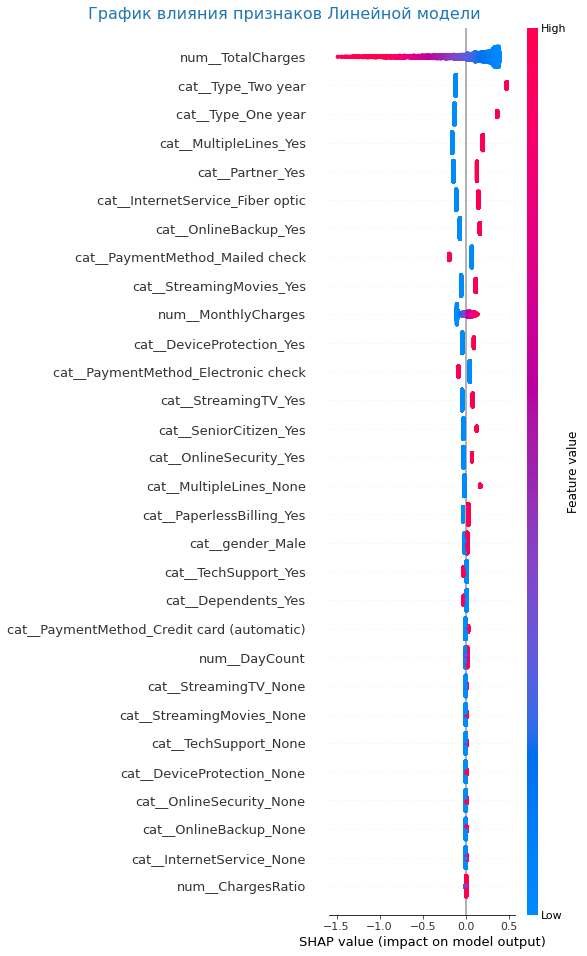

In [69]:
shap.plots.beeswarm(shap_values, max_display=30, show=False)
add_plot_titles(suptitle="График влияния признаков Линейной модели", show=True)

Общие расходы имеют обратное влияние на значения модели, т.е. более низкие значения этого признака склоняют модель больше в пользу целевой группы. Также обратное влияние оказывают признаки типа оплаты `Mailed check` и `Electronic check`, наличия техподдержки и наличие детей, остальные признаки оказывают прямое влияние. Допольно сильное влияние оказывают признаки оплаты 2 года и 1 год.

### Random Forest

Для случайного леса будем использовать кодирование категориальных признаков посредством CatBoostEncoder, числовые признаки оставим как есть.

In [70]:
rf_prep = ColumnTransformer(transformers=[
    ("cat", CatBoostEncoder(), cat_cols)
], remainder="passthrough")

X_rf = rf_prep.fit_transform(X_train, y_train)
X_rf = pd.DataFrame(X_rf, columns=rf_prep.get_feature_names_out())
X_rf

,cat__Type,cat__PaperlessBilling,cat__PaymentMethod,cat__gender,cat__SeniorCitizen,cat__Partner,cat__Dependents,cat__InternetService,cat__OnlineSecurity,cat__OnlineBackup,cat__DeviceProtection,cat__TechSupport,cat__StreamingTV,cat__StreamingMovies,cat__MultipleLines,remainder__MonthlyCharges,remainder__TotalCharges,remainder__DayCount,remainder__ChargesRatio
0,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,109.95,8153.89,2191.0,0.970874
1,0.156439,0.156439,0.156439,0.156439,0.078220,0.156439,0.078220,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,0.156439,19.40,380.63,549.0,0.917426
2,0.078220,0.078220,0.156439,0.078220,0.052146,0.078220,0.052146,0.156439,0.156439,0.156439,0.078220,0.156439,0.078220,0.078220,0.156439,44.60,294.36,184.0,0.909091
3,0.156439,0.052146,0.078220,0.052146,0.039110,0.078220,0.039110,0.078220,0.078220,0.078220,0.052146,0.078220,0.156439,0.156439,0.078220,41.15,1604.85,1187.0,1.000000
4,0.052146,0.078220,0.052146,0.039110,0.031288,0.052146,0.031288,0.052146,0.052146,0.078220,0.156439,0.078220,0.078220,0.052146,0.052146,45.30,2265.00,1522.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,0.225803,0.171314,0.202414,0.151599,0.145991,0.210235,0.176793,0.109485,0.109485,0.109485,0.109485,0.109485,0.109485,0.109485,0.225283,24.05,1731.60,2191.0,1.000000
5276,0.208399,0.135320,0.210664,0.161433,0.145958,0.210152,0.176681,0.109389,0.109389,0.109389,0.109389,0.109389,0.109389,0.109389,0.225182,24.10,96.40,123.0,1.000000
5277,0.225627,0.135258,0.202237,0.151540,0.145925,0.210070,0.147960,0.109293,0.109293,0.109293,0.109293,0.109293,0.109293,0.109293,0.095769,19.90,1213.70,1737.0,0.934580
5278,0.105647,0.171259,0.147713,0.161373,0.145892,0.106952,0.147920,0.190339,0.149069,0.221882,0.125866,0.157143,0.125961,0.223234,0.225081,90.05,630.35,215.0,1.000000


In [71]:
# Переменная для результатов кросс-валидации
rf_cv_results = {
    "Метрика ROC-AUC": [],
    "Метрика Accuracy": [],
    "Время обучения": [],
    "Время предсказания": []
}

# Функция подбора гиперпараметров
def rf_optimize(trial):
    n_estimators = trial.suggest_int("n_estimators", 250, 300, step=10)
    max_depth = trial.suggest_int("max_depth", 17, 22)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 15)
    
    pipeline = Pipeline([
        ("preprocessor", rf_prep),
        ("model", RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            n_jobs=-1, random_state=RANDOM_STATE,
            class_weight="balanced"
        ))
    ])
    
    cv_result = cross_validate(
        pipeline, X_train, y_train,
        cv=CV, n_jobs=-1, scoring=SCORING
        , error_score="raise"
    )
    
    rf_cv_results["Метрика ROC-AUC"].append(cv_result["test_roc_auc"].mean())
    rf_cv_results["Метрика Accuracy"].append(cv_result["test_accuracy"].mean())
    rf_cv_results["Время обучения"].append(cv_result["fit_time"].mean())
    rf_cv_results["Время предсказания"].append(cv_result["score_time"].mean())
    
    return cv_result["test_roc_auc"].mean()

# Подбор гиперпараметров
rf_study = optuna.create_study(
        direction="maximize", study_name="RandomForest", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
rf_study.optimize(rf_optimize, n_trials=16, show_progress_bar=True)

  0%|          | 0/16 [00:00<?, ?it/s]

In [72]:
rf_cv_results = pd.DataFrame(rf_cv_results)

# Сохранение рузльтатов для сравнения
model_cv_results["RandomForest"] = rf_cv_results.loc[rf_study.best_trial.number]

# Вывод результатов
print("Лучшие гиперпараметры:", rf_study.best_params)
print("Результаты кросс-валидации:")
rf_cv_results.loc[rf_study.best_trial.number]

Лучшие гиперпараметры: {'n_estimators': 290, 'max_depth': 18, 'min_samples_split': 22, 'min_samples_leaf': 12}
Результаты кросс-валидации:


Метрика ROC-AUC       0.813601
Метрика Accuracy      0.831061
Время обучения        3.295813
Время предсказания    0.187603
Name: 13, dtype: float64

Метрика ROC-AUC существенно улучшилась по сравнению с линейной моделью, однако она также не достигла целевого значения. Время обучения также достаточно 


Взглянем на важность признаков модели случайного леса.

In [73]:
# Обучение модели
rf_model = RandomForestClassifier(
    n_estimators=rf_study.best_params["n_estimators"],
    max_depth=rf_study.best_params["max_depth"],
    min_samples_split=rf_study.best_params["min_samples_split"],
    min_samples_leaf=rf_study.best_params["min_samples_leaf"],
    n_jobs=-1, random_state=RANDOM_STATE,
    class_weight="balanced"
)
rf_model.fit(X_rf, y_train)

# Получение значений SHAP
shap_explainer = shap.TreeExplainer(rf_model)
shap_values = shap_explainer(X_rf, check_additivity=False)

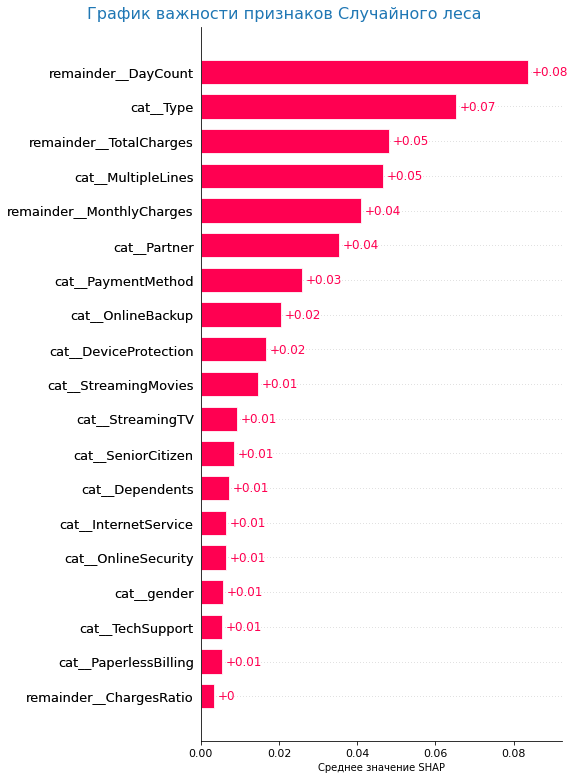

In [74]:
shap.plots.bar(shap_values[:, :, 1], max_display=19, show=False)
add_plot_titles(
    suptitle="График важности признаков Случайного леса", show=True,
    xlabel="Среднее значение SHAP"
)

Для модели деревьев решений наиболее важным признаком выступает длительность договора, чуть ниже по важности идет признак типа оплаты. Далее располагаются признаки общих и месячных затрат, а также наличия телефона. Далее по ниспадающей идут признаки наличия партнера, метода оплаты, различных Интернет-услуг. Наименьшее влияние дополнительного признака отношения месячных затрат к средним.

### CatBoost

In [75]:
cb_prep = ColumnTransformer(transformers=[
    ("cat", SimpleImputer(strategy="constant", fill_value="None"), cat_cols),
    ("num", SimpleImputer(strategy="constant", fill_value=0), num_cols)
], remainder="drop")

X_cb = cb_prep.fit_transform(X_train, y_train)
X_cb = pd.DataFrame(X_cb, columns=cb_prep.get_feature_names_out())
X_cb

,cat__Type,cat__PaperlessBilling,cat__PaymentMethod,cat__gender,cat__SeniorCitizen,cat__Partner,cat__Dependents,cat__InternetService,cat__OnlineSecurity,cat__OnlineBackup,cat__DeviceProtection,cat__TechSupport,cat__StreamingTV,cat__StreamingMovies,cat__MultipleLines,num__MonthlyCharges,num__TotalCharges,num__DayCount,num__ChargesRatio
0,Two year,Yes,Credit card (automatic),Male,No,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes,109.95,8153.89,2191.0,0.970874
1,Month-to-month,No,Bank transfer (automatic),Female,No,No,No,None,None,None,None,None,None,None,No,19.4,380.63,549.0,0.917426
2,Month-to-month,No,Electronic check,Female,No,Yes,No,DSL,No,No,No,No,Yes,Yes,None,44.6,294.36,184.0,0.909091
3,One year,No,Bank transfer (automatic),Female,No,No,No,DSL,Yes,Yes,No,Yes,No,No,None,41.15,1604.85,1187.0,1.0
4,Month-to-month,Yes,Bank transfer (automatic),Female,No,Yes,No,DSL,Yes,No,Yes,No,No,Yes,None,45.3,2265.0,1522.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,Two year,Yes,Bank transfer (automatic),Female,No,Yes,Yes,None,None,None,None,None,None,None,Yes,24.05,1731.6,2191.0,1.0
5276,One year,No,Credit card (automatic),Male,No,Yes,Yes,None,None,None,None,None,None,None,Yes,24.1,96.4,123.0,1.0
5277,Two year,No,Bank transfer (automatic),Female,No,Yes,No,None,None,None,None,None,None,None,No,19.9,1213.7,1737.0,0.93458
5278,Month-to-month,Yes,Electronic check,Male,No,No,No,Fiber optic,No,Yes,No,No,No,Yes,Yes,90.05,630.35,215.0,1.0


In [76]:
# Переменная для результатов кросс-валидации
cb_cv_results = {
    "Метрика ROC-AUC": [],
    "Метрика Accuracy": [],
    "Время обучения": [],
    "Время предсказания": []
}

# Функция подбора гиперпараметров
def cb_optimize(trial):
    iterations = trial.suggest_int("iterations", 500, 1000, step=100)
    depth = trial.suggest_int("depth", 5, 7)
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.1, step=0.01)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 2, 5)
    
    pipeline = Pipeline([
        ("preprocessor", cb_prep),
        ("model", cb.CatBoostClassifier(
            cat_features=list(range(len(cat_cols))),
            iterations=iterations,
            depth=depth, 
            learning_rate=learning_rate, 
            l2_leaf_reg=l2_leaf_reg,
            thread_count=-1, verbose=0,
            random_seed=RANDOM_STATE,
            early_stopping_rounds=None,
            auto_class_weights="Balanced"
        ))
    ])
    
    cv_result = cross_validate(
        pipeline, X_train, y_train,
        cv=CV, scoring=SCORING, 
        n_jobs=-1, # if get_gpu_device_count() > 0 else 1, 
        error_score="raise"
    )
    
    cb_cv_results["Метрика ROC-AUC"].append(cv_result["test_roc_auc"].mean())
    cb_cv_results["Метрика Accuracy"].append(cv_result["test_accuracy"].mean())
    cb_cv_results["Время обучения"].append(cv_result["fit_time"].mean())
    cb_cv_results["Время предсказания"].append(cv_result["score_time"].mean())
    
    return cv_result["test_roc_auc"].mean()

# Подбор гиперпараметров
cb_study = optuna.create_study(
        direction="maximize", study_name="CatBoost", 
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
# Так как при используемой сеткой гиперпараметров лучшее значение на итерации 2,
# а время обучения довольно длительное, оставил 4 итерации поиска
cb_study.optimize(cb_optimize, n_trials=4, show_progress_bar=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [77]:
cb_cv_results = pd.DataFrame(cb_cv_results)

# Сохранение рузультатов для сравнения
model_cv_results["CatBoost"] = cb_cv_results.loc[cb_study.best_trial.number]

# Вывод результатов
print("Лучшие гиперпараметры:", cb_study.best_params)
print("Результаты кросс-валидации:")
cb_cv_results.loc[cb_study.best_trial.number]

Лучшие гиперпараметры: {'iterations': 900, 'depth': 5, 'learning_rate': 0.09, 'l2_leaf_reg': 2}
Результаты кросс-валидации:


Метрика ROC-AUC       0.897907
Метрика Accuracy      0.883523
Время обучения        9.366141
Время предсказания    0.032337
Name: 2, dtype: float64

Значение метрики ROC-AUC CatBoost существенно выше модели случайного леса и достигает среднего значения при кросс-валидации близкого к 0.9 на тренировочной выборке. Время обучения модели довольно сильно выросло, но явно такое время не является критическим, так как переобучение модели не будет производиться достаточно часто исходя из поставленной задачи, где новые договора могут накапливаться в течение месяца.

Оценим важность признаков.

In [78]:
# Обучение модели на тренировочной выборке
cb_model = cb.CatBoostClassifier(
    cat_features=list(range(len(cat_cols))),
    iterations=cb_study.best_params["iterations"],
    depth=cb_study.best_params["depth"],
    learning_rate=cb_study.best_params["learning_rate"],
    l2_leaf_reg=cb_study.best_params["l2_leaf_reg"],
    thread_count=-1, verbose=0,
    random_seed=RANDOM_STATE,
    early_stopping_rounds=None,
    auto_class_weights="Balanced"
)
cb_model.fit(X_cb, y_train)

# Получение SHAP значений
shap_explainer = shap.TreeExplainer(cb_model)
shap_values = shap_explainer(X_cb)

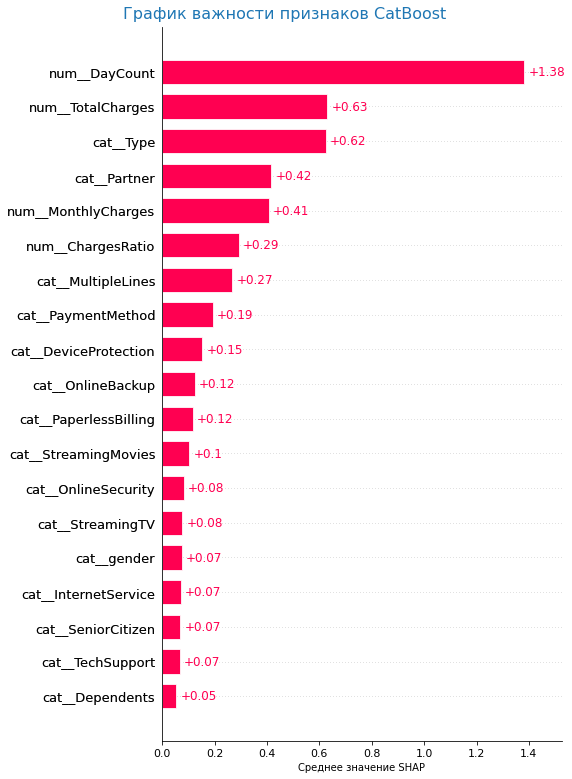

In [79]:
shap.plots.bar(shap_values, max_display=19, show=False)
add_plot_titles(
    suptitle="График важности признаков CatBoost", show=True,
    xlabel="Среднее значение SHAP"
)

Для модели CatBoost на первом месте, как и для модели Random Forest, стоит признак длительности договора. Однако для данной модели он имеет сущетственно большее значение. Чуть большую важность также получил признак общих расходов и сместил признак типа оплаты. Также поднялась важность признаков наличия партнера и месячных расходов. По сравнению с предыдущей моделью значительно поднялась важность нового признака отношения месячных расходов к средним расходам с последней позиции до 6-й по важности. Важность признака наличия телефона сместилась ниже, а признак наличия детей спустился на саму низкую позицию по важности.

### Промежуточные итоги

Произведено обучение 3-х моделей - линейная модель в качестве базовой и две ансамблевые модели - Random Forest и CatBoost. Для моделей произведены различные операции кодирования и масштабирования данных: 
- для линейной модели категориальные признаки закодированы посредством OneHotEncoder и применено масштабирование числовых признаков посредством StandardScaler;
- для модели RandomForest проведено только кодирование категориальных признаков посредством довольно продвинутого метода CatBoostEncoder без масштабирования числовых признаков, так как основанные на деревьях решений модели не зависят от масштаба признаков;
- для модели CatBoost не производилось никакого кодирования и масштабирования, так как данная модель может кодировать категориальные признаки, однако сохранена предобработка для заполнения пропущенных значений на случай получения выборки с пропусками. Стоит отметить, что все пропуски числовых значений будут заполнены нулями, а категориальных значением `None`, которое применяется для отсутствующих значений в выборке.

По результатам обучения и подбора гиперпараметров, только модель CatBoost превысила целевое значение метрики ROC-AUC на тренировочной выборке. В целом распределение результатов следующее:
1. Линейная модель
    - ROC-AUC: 0.755;
    - Accuracy: 0.695.
2. Random Forest
    - ROC-AUC: 0.814;
    - Accuracy: 0.83.
3. CatBoost
    - ROC-AUC: 0.898
    - Accuracy: 0.88.
    
По времени обучени модели распределились в обратной последовательности, причем CatBoost уступает линейной модели практически в 10 раз, но существенно более низким временем предсказания.

## Выбор лучшей модели

In [80]:
model_cv_results.columns.names=["Модель"]
print("Результаты моделей:")
model_cv_results.style.background_gradient(
    cmap=sns.diverging_palette(250, 25, as_cmap=True),
    axis=1
)

Результаты моделей:


Модель,Ridge,RandomForest,CatBoost
Метрика ROC-AUC,0.755421,0.813601,0.897907
Метрика Accuracy,0.695455,0.831061,0.883523
Время обучения,0.195233,3.295813,9.366141
Время предсказания,0.177563,0.187603,0.032337


Очевидно, что единственной моделью, которая проходит ограничения поставленной задачи является модель CatBoost, значение метрики ROC-AUC которой приближается к 0.9, проведем оценку модели на тестовой выборке.

In [81]:
# Подготовка пайплайна
pipeline = Pipeline([
    ("preprocessor", cb_prep),
    ("model", cb_model)
])

# Получение результатов
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

In [82]:
# Получение метрик на тестовой выборке
auc = roc_auc_score(y_test, y_proba[:, 1])
acc = accuracy_score(y_test, y_pred)
print("Значение ROC-AUC на тестовой выборке:", auc)
print("Значение Accuracy на тестовой выборке:", acc)

Значение ROC-AUC на тестовой выборке: 0.9113764835433745
Значение Accuracy на тестовой выборке: 0.8898353208404316


На тестовой выборке значение метрики ROC-AUC существенно выше ограничения и превышает 0.9, значение метрики Accuracy составляет порядка 0.889, что означает практически 90% точность предсказания модели.

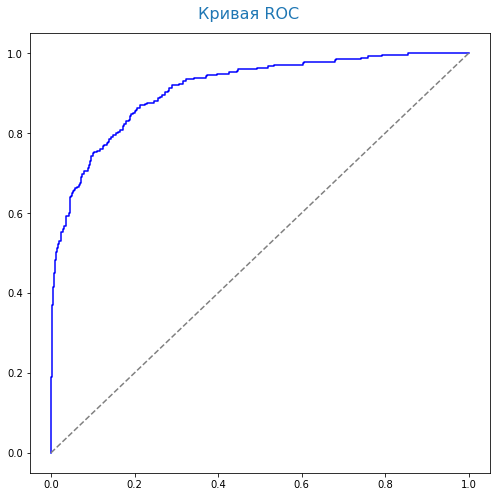

In [83]:
# Вывод кривой ROC
fpr, tpr, ts = roc_curve(y_test, y_proba[:, 1])

# Визуализация ROC-кривой с выводом значений thresholds
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
add_plot_titles(
    suptitle="Кривая ROC",
    show=True    
)

ROC-кривая (Receiver Operating Characteristic) визуализирует качество модели классификации, показывая баланс между True Positive Rate (TPR), которое определяется как отношение всех корректных позитивных предсказаний ко всем позитивным предсказаниям и False Positive Rate (FPR), которое определяется как отношение всех корректных отрицательных предсказаний ко всем отрицательным предсказаниям. ROC-кривая помогает понять, насколько хорошо модель отличает положительные примеры от отрицательных.

Метрика ROC-AUC (Area Under the ROC Curve) является площадью под кривой ROC и отражает способность модели отделять положительные классы от отрицательных. Чем больше площадь под кривой, тем лучше модель классифицирует объекты на положительный и отрицательный классы.

По данной выборке общая предсказательная способность модели приближается к 90% точных предсказаний (метрика Accuracy), однако имеются ложные предсказания. Посредством матрицы ошибок оценим какие предсказания модель делает лучше.

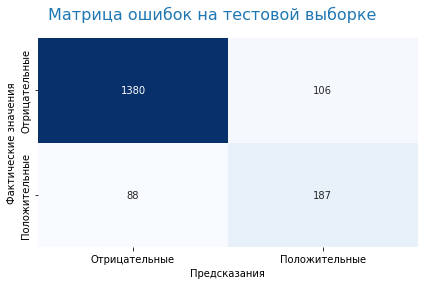

In [84]:
# Создаем матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=["Отрицательные", "Положительные"], 
    yticklabels=["Отрицательные", "Положительные"]
)
add_plot_titles(
    suptitle="Матрица ошибок на тестовой выборке",
    xlabel="Предсказания", ylabel="Фактические значения",
    show=True
)

В соответствии с матрицей ошибок, достаточно большую часть тестовой выборки составляют клиенты не целевой группы, которую модель достаточно хорошо предсказывает. Однако для целевой группы значения выглядят достаточно плохо, так как довольно большое количество ложноотрицательных предсказаний - порядка 32% от целевой группы предсказаны неверно. Оценим распределение месячных расходов таких клиентов, возможно модель неверно предсказывает только клиентов определенной группы.

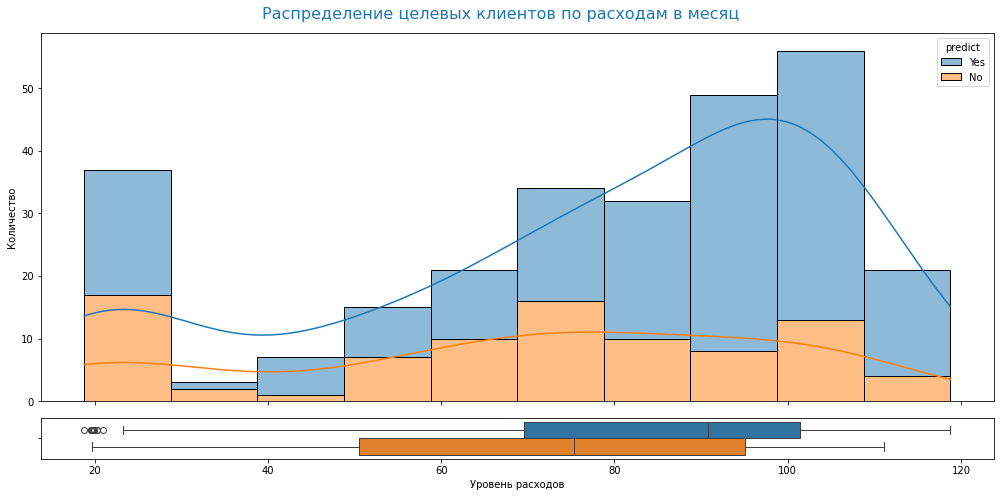

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
predict,,,,,,,,,,,,,,
Yes,187.00,81.49,27.10,18.80,18.99,19.64,69.55,90.80,101.35,116.39,118.62,118.75,Probably NOT,0.00
No,88.00,68.76,29.34,19.70,19.71,19.74,50.55,75.35,95.11,110.88,111.03,111.05,Probably NOT,0.00


In [85]:
value = {1: "Yes", 0: "No"}
test["predict"] = [value[x] for x in y_pred]
show_num(
    test.query("target == 1"), x="MonthlyCharges", hue="predict", figsize=(14, 7),
    suptitle="Распределение целевых клиентов по расходам в месяц",
    xlabel="Уровень расходов", ylabel="Количество"
)

По неверно предсказанным целевым клиентам значения расходов сдвинуто к более низким значениям. Если среднее значение месячных расходов для верно предсказанных клиентов составляет 90.8, то для ложноотрицательных такое значение составляет 75.35. Также все показатели достаточно сдвинуты к нижним значениям, следовательно в целом это клиенты, приносящие более низкий доход. Оценим также и срок действия договоров таких клиентов.

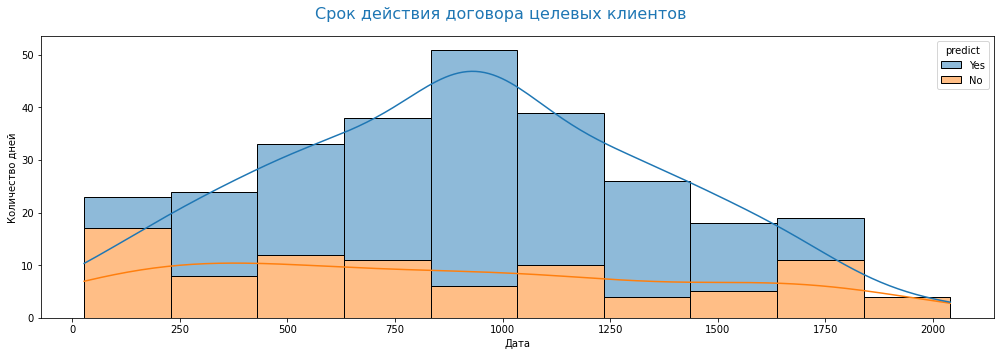

,count,mean,std,min,0.1%,1%,25%,50%,75%,99%,99.9%,max,Gaussian,p_value
predict,,,,,,,,,,,,,,
Yes,187.00,937.65,385.57,61.00,61.24,112.74,654.50,943.00,"1,218.00","1,679.06","1,749.49","1,764.00",Probably,0.13
No,88.00,861.08,583.09,28.00,28.23,29.74,365.00,792.00,"1,255.75","1,933.86","2,026.20","2,040.00",Probably NOT,0.00


In [86]:
show_num(
    test.query("target == 1"), x="DayCount", hue="predict",
    suptitle="Срок действия договора целевых клиентов", 
    xlabel="Дата", ylabel="Количество дней", boxplot=False
)

Модель неплохо предсказывает целевую группу клиентов со средним сроком действия договора, однако довольно плохо предсказывает отток новых клиентов, а также старых клиентов, имеющих наибольшую длительность действия договора.

### Промежуточные итоги

Лучшей признана модель CatBoost, которая с запасом преодолела ограничения задачи на тренировочной выборке. Произведено предсказание на тестовой выборке, результаты которой превзошли средние значения кросс-валидации на тренировочной выборке:
- ROC-AUC = 0.91;
- Accuracy = 0.89.

Проведена оценка матрицы ошибок, по результатам которой выявлено наличие достаточно высокого количества ложноотрицательных результатов - 32% целевой группы клиентов предсказано неверно, несмотря на общую высокую предсказательную способность модели в районе 90%.

Дополнительно произведена оценка ложноотрицательных предсказаний, по которым можно отметить довольно высокую точность для наибольшей части целевой группы клиентов, однако низкие показания для новых клиентов и очень низкие для самых старых клиентов. Однако средние расходы за месяц для неверно предсказанных целевых клиентов в целом ниже, что может оказать меньшее влияение на финансовые показатели Заказчика. Однако лучше рассмотреть возможность выбора другой целевой метрики, такой как Recall для повышения охвата целевой группы.

## Общий вывод и рекомендации заказчику

В рамках проекта произведен исследовательский анализ предоставленных данных. В качестве целевого признака определены значения даты завершения договора - если дата имеется, то это целевая группа. По значениям предоставленных датасетов аномалии не выявлены, данные подготовлены для работы моделей машинного обучения.

В части проведенного исследовательского анализа можно отметить следующее:
1. Имеется диспропорция целевой группы, вследствие чего модель может хуже предсказывать целевую группу.
2. Обнаружено, что средние расходы за месяц могут быть выше месячных расходов. Если это не является нормой для оказываемых услуг, например, не практикуется доплата за превышение каких-либо установленных лимитов услуг, то лучше обратить на это внимание. Либо часть пользователей только снижает количество используемых услуг, вследствие чего месячные расходы уменьшаются.
3. Целевой признак не имеет высокой корреляции с остальными признаками, также наблюдается мультиколлинеарность признаков Интернет-услуг, высокая корреляция услуг с расходами клиентов, а также умеренная корреляция между типами оплаты.

В рамках исследовательского анализа предложен портрет целевого клиента:
1. Целевая группа клиентов это в основном не новые пользователи услуг, половина таких клиентов расторгает договор по прошествии от полутора до более 4-х лет оказания услуг.
2. Часто такие клиенты пользуются как Интернет-услугами, так и услугами телефонии. При этом зачастую клиенты пользуются дополнительными Интернет-услугами - более 50% были подписаны на стриминговое телевидение и каталог фильмов, а также другие услуги но в меньшей пропорции, также такие клиенты чаще пользуются несколькими телефонными линиями. Соответственно целевая группа клиентов в среднем приносит больший доход Заказчику, чем основная масса клиентов - средний месячный расход составляет 84 против 69 для остальных клиентов, а средние общие расходы составляют порядка 2'139 против 1'192 для остальных клиентов.
3. Целевая группа клиентов реже чем остальные клиенты использует ежемесячную оплату - большая часть клиентов имеет двухгодовую или годовую подписку, а также предпочитает электронные или автоматические типы платежа.
4. Это преимущественно семейные клиенты, хотя по наличию детей целевая группа не сильно отличается от остальных клиентов и чаще всего не имеет детей.

Несмотря на то, что целевой признак имеет низкую корреляцию с остальными, в качестве базовой выбрана линейная модель для оценки результатов других моделей. В виду наличия мультиколлинеарности признаков, выбрана линейная модель с L2 регуляризацией. В качестве основных моделей выбраны ансамблевые модели - RandomForest и наиболее предпочтительной определена модель CatBoost в виду наличия достаточно большого количества категориальных признаков.

Произведено разделение моделей на тренировочную и тестовую выборки, а также проведено обучение моделей и оценка важности признаков на тренировочной выборке. По результатам обучения моделей, наивысший результат получила модель CatBoost, целевая метрика ROC-AUC которой превысила ограничения по заданию практически на 5%. Результаты на тестовой выборке превзошли целевые более чем на 6%.

Несмотря на достаточно высокие показатели целевой метрики на тестовой выборке, можно отметить, что в виду несбалансированности выборки не в пользу целевой группы клиентов, по ней имеется достаточно высокое количество ложноотрицательных предсказаний - 32% от целевой группы. Желательно рассмотреть использование метрики Recall для максимального охвата целевой группы. В этом случае небходимо оценить возможное влияние использования клиентами специальных условий и промокодов на финансовые показатели Заказчика, так как вероятнее всего возрастет количество ложноположительных предсказаний, а для этого необходимо получение дополнительной информации о влиянии услуг и специальных условий на чистую прибыль Заказчика, либо проведение такого исследования Заказчиком самостоятельно.

В целях улучшения модели прогнозирования оттока клиентов можно дополнительно рекомендовать проведение оценки уровня удовлетворенности клиентов услугами Заказчика для обучения моделей с учетом таких данных.

В целях подведения итогов проекта по прогнозированию оттока клиентов Заказчика, можно отметить следующее:
1. Подготовлена модель машинного обучения, целевая метрика которой удовлетворяет ограничениям поставленной задачи и превосходит целевое значение в среднем на 5%;
2. Рекомендуется рассмотреть возможность использования метрики Recall для минимизации ложноотрицательных предсказаний с учетом возможного влияния на финансовые показатели Заказчика;
3. Дополнительно рекомендуется производить оценку уровня удовлетворенности клиентов услугами Заказчика для дальнейшего улучшения модели предсказания оттока клиентов.